In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import datetime

from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

In [6]:
train = pd.read_csv('train.csv', parse_dates=['first_active_month'])

In [7]:
for df in [train]:
    df["first_year"] = df["first_active_month"].dt.year
    df["first_month"] = df["first_active_month"].dt.year
    df['first_year'] = df['first_year'].fillna(df['first_year'].median())
    df['first_month'] = df['first_month'].fillna(df['first_month'].median())
    df.drop(['first_active_month'], axis=1, inplace=True)

In [8]:
agg_func = {}
for column in train.columns:
    if column not in ('card_id', 'target'):
        agg_func[column] = ['std']
# train = train.groupby(by='card_id').agg(agg_func)

In [175]:
for df in [train]:
    df.columns = ['_'.join(col).strip() for col in df.columns.values]
    df['card_id'] = df.index

In [177]:
train = pd.read_csv('train.csv', parse_dates=['first_active_month'])

for df in [train]:
    df["first_year"] = df["first_active_month"].dt.year
    df["first_month"] = df["first_active_month"].dt.year
    df['first_year'] = df['first_year'].fillna(df['first_year'].median())
    df['first_month'] = df['first_month'].fillna(df['first_month'].median())
    df.drop(['first_active_month'], axis=1, inplace=True)

agg_func = {}
for column in train.columns:
    if column not in ('card_id', 'target'):
        agg_func[column] = ['var']
# train = train.groupby(by='card_id').agg(agg_func)

# for df in [train]:
#     df.columns = ['_'.join(col).strip() for col in df.columns.values]
#     df['card_id'] = df.index

train.corr()

,feature_1,feature_2,feature_3,target,first_year,first_month
feature_1,1.000000,-0.130969,0.583092,-0.014251,-0.115267,-0.115267
feature_2,-0.130969,1.000000,0.060925,-0.006242,-0.151782,-0.151782
feature_3,0.583092,0.060925,1.000000,-0.008125,-0.194084,-0.194084
target,-0.014251,-0.006242,-0.008125,1.000000,0.040341,0.040341
first_year,-0.115267,-0.151782,-0.194084,0.040341,1.000000,1.000000
first_month,-0.115267,-0.151782,-0.194084,0.040341,1.000000,1.000000


In [171]:
train.head()

,card_id,feature_1,feature_2,feature_3,target,first_year,first_month
0,C_ID_92a2005557,5,2,1,-0.820283,2017,2017
1,C_ID_3d0044924f,4,1,0,0.392913,2017,2017
2,C_ID_d639edf6cd,2,2,0,0.688056,2016,2016
3,C_ID_186d6a6901,4,3,0,0.142495,2017,2017
4,C_ID_cdbd2c0db2,1,3,0,-0.159749,2017,2017


In [156]:
test = pd.read_csv('test.csv', parse_dates=['first_active_month'])

In [157]:
for df in [test]:
    df["first_year"] = df["first_active_month"].dt.year
    df["first_month"] = df["first_active_month"].dt.year
#     df['first_year'] = df['first_year'].fillna(df['first_year'].median())
#     df['first_month'] = df['first_month'].fillna(df['first_month'].median())
    df.drop(['first_active_month'], axis=1, inplace=True)

In [158]:
agg_func = {}
for column in test.columns:
    if column not in ('card_id', 'target'):
        agg_func[column] = ['min']
# test = test.groupby(by='card_id').agg(agg_func)

In [154]:
for df in [test]:
    df.columns = ['_'.join(col).strip() for col in df.columns.values]
    df['card_id'] = df.index

In [3]:
train = pd.read_csv('train.csv', parse_dates=['first_active_month'])
test = pd.read_csv('test.csv', parse_dates=['first_active_month'])
historical_transactions = pd.read_csv('historical_transactions.csv')
merchants = pd.read_csv('merchants.csv')
new_merchant_transactions = pd.read_csv('new_merchant_transactions.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [4]:
joined_dfs = pd.concat([historical_transactions, new_merchant_transactions])
joined_dfs = joined_dfs[['card_id', 'merchant_id']]
merchants = pd.merge(joined_dfs, merchants, on='merchant_id')

In [5]:
# Work done on Train & Test datasets
train['elapsed_time'] = (datetime.date(2018, 2, 1) - train['first_active_month'].dt.date).dt.days
test['elapsed_time'] = (datetime.date(2018, 2, 1) - test['first_active_month'].dt.date).dt.days

train_target = train[['card_id', 'target']]

for df in [train, test]:
    df["first_year"] = df["first_active_month"].dt.year
    df["first_month"] = df["first_active_month"].dt.year
    df['first_year'] = df['first_year'].fillna(df['first_year'].median())
    df['first_month'] = df['first_month'].fillna(df['first_month'].median())
    df.drop(['first_active_month'], axis=1, inplace=True)

# Work done on historical, new_merchant and merchants datasets 
historical_transactions = historical_transactions[historical_transactions['merchant_id'].notnull()]
new_merchant_transactions = new_merchant_transactions[new_merchant_transactions['merchant_id'].notnull()]

for df in [historical_transactions, new_merchant_transactions]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['purchase_year'] = df["purchase_date"].dt.year
    df["purchase_month"] = df["purchase_date"].dt.month
    df.drop(['purchase_date', 'category_2', 'category_3'], axis=1, inplace=True)

for column in ['avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12']:
        merchants[column] = merchants[column].fillna(merchants[column].median())
        
merchants.drop(['category_2'], axis=1, inplace=True)

# historical_transactions.columns = 'hist' + '_' + historical_transactions.columns
# new_merchant_transactions.columns = 'new' + '_' + new_merchant_transactions.columns

# for df in [train, test]:
#     df.rename(columns={'card_id': 'hist_card_id'}, inplace=True)
#     df = pd.merge(df, historical_transactions, on='hist_card_id')
#     df.rename(columns={'hist_card_id': 'new_card_id'}, inplace=True)
#     df = pd.merge(df, new_merchant_transactions, on='new_card_id')
#     merchants.rename(columns={'merchant_id': 'new_merchant_id'}, inplace=True)
#     df = pd.merge(df, merchants, on='new_merchant_id')
    
    
# train.rename(columns={'card_id': 'hist_card_id'}, inplace=True)
# new_train = pd.merge(train, historical_transactions, on='hist_card_id')
# new_train.rename(columns={'hist_card_id': 'new_card_id'}, inplace=True)
# new_train = pd.merge(new_train, new_merchant_transactions, on='new_card_id')
# new_train = pd.merge(new_train, merchants, on='merchant_id')

# new_train = pd.merge(train, historical_transactions, on='card_id')
# new_train = pd.merge(new_train, new_merchant_transactions, on='card_id')
# new_train = pd.merge(new_train, merchants, on='merchant_id')

In [6]:
for df in [historical_transactions, new_merchant_transactions]:
    for column in ['authorized_flag', 'category_1']:
        df[column] = df[column].map({'Y':1, 'N':0})
            
for df in [merchants]:
    for column in ['category_1', 'category_4']:
        df[column] = df[column].map({'Y':1, 'N':0})

    for column in ['most_recent_sales_range', 'most_recent_purchases_range']:
        df[column] = df[column].map({'A':1, 'B':0, 'C':3, 'D':4, 'E':5})

In [7]:
# agg_func = {}
# for column in train.columns:
#     if column not in ('card_id', 'target'):
#         agg_func[column] = ['min', 'max', 'sum', 'nunique', 'count', 'mean', 'median', 'std']
# # train = train.groupby(by='card_id').agg(agg_func)
       
# agg_func = {}
# for column in test.columns:
#     if column not in  ('card_id'):
#         agg_func[column] = ['min', 'max', 'sum', 'nunique', 'count', 'mean', 'median', 'std']
# # test = test.groupby(by='card_id').agg(agg_func)

agg_func = {}
for column in historical_transactions.columns:
    if column not in  ('card_id', 'merchant_id'):
        agg_func[column] = ['min', 'max', 'sum', 'nunique', 'count', 'mean', 'median', 'std']
historical_transactions = historical_transactions.groupby(by='card_id').agg(agg_func)

agg_func = {}
for column in new_merchant_transactions.columns:
    if column not in  ('card_id', 'merchant_id'):
        agg_func[column] = ['min', 'max', 'sum', 'nunique', 'count', 'mean', 'median', 'std']
new_merchant_transactions = new_merchant_transactions.groupby(by='card_id').agg(agg_func)

agg_func = {}
for column in merchants.columns:
    if column not in ('card_id', 'merchant_id'):
        agg_func[column] = ['min', 'max', 'sum', 'nunique', 'count', 'mean', 'median', 'std']
    if column in ('merchant_id'):
        agg_func[column] = ['count']
merchants = merchants.groupby(by='card_id').agg(agg_func)

In [7]:
agg_func = {}
for column in train.columns:
    if column not in ('card_id', 'target'):
        agg_func[column] = ['min', 'max', 'sum', 'nunique', 'count', 'mean', 'median', 'std']
train = train.groupby(by='card_id').agg(agg_func)
       
agg_func = {}
for column in test.columns:
    if column not in  ('card_id'):
        agg_func[column] = ['min', 'max', 'sum', 'nunique', 'count', 'mean', 'median', 'std']
test = test.groupby(by='card_id').agg(agg_func)

agg_func = {}
for column in historical_transactions.columns:
    if column not in  ('card_id', 'merchant_id'):
        agg_func[column] = ['min', 'max', 'sum', 'nunique', 'count', 'mean', 'median', 'std']
historical_transactions = historical_transactions.groupby(by='card_id').agg(agg_func)

agg_func = {}
for column in new_merchant_transactions.columns:
    if column not in  ('card_id', 'merchant_id'):
        agg_func[column] = ['min', 'max', 'sum', 'nunique', 'count', 'mean', 'median', 'std']
new_merchant_transactions = new_merchant_transactions.groupby(by='card_id').agg(agg_func)

agg_func = {}
for column in merchants.columns:
    if column not in ('card_id', 'merchant_id'):
        agg_func[column] = ['min', 'max', 'sum', 'nunique', 'count', 'mean', 'median', 'std']
    if column in ('merchant_id'):
        agg_func[column] = ['count']
merchants = merchants.groupby(by='card_id').agg(agg_func)

In [8]:
for df in [historical_transactions, new_merchant_transactions, merchants]:
    df.columns = ['_'.join(col).strip() for col in df.columns.values]
    df['card_id'] = df.index
    
counter = 0
abr = ['his', 'new', 'mer']
for df in [historical_transactions, new_merchant_transactions, merchants]:
    df.columns = abr[counter] + '_' + df.columns
    df.rename(columns={df.columns[-1]: 'card_id'}, inplace=True)
    counter += 1

# train.columns = 'tra' + '_' + train.columns
# test.columns = 'tes' + '_' + test.columns
# historical_transactions.columns = 'hist' + '_' + historical_transactions.columns
# new_merchant_transactions.columns = 'new' + '_' + new_merchant_transactions.columns
# merchants.columns = 'mer' + '_' + merchants.columns

# for df in [train, test, historical_transactions, new_merchant_transactions, merchants]:
#     df.rename(columns={df.columns[-1]: 'card_id'}, inplace=True)

In [8]:
for df in [train, test, historical_transactions, new_merchant_transactions, merchants]:
    df.columns = ['_'.join(col).strip() for col in df.columns.values]
    df['card_id'] = df.index
    
counter = 0
abr = ['tra', 'tes', 'his', 'new', 'mer']
for df in [train, test, historical_transactions, new_merchant_transactions, merchants]:
    df.columns = abr[counter] + '_' + df.columns
    df.rename(columns={df.columns[-1]: 'card_id'}, inplace=True)
    counter += 1

# train.columns = 'tra' + '_' + train.columns
# test.columns = 'tes' + '_' + test.columns
# historical_transactions.columns = 'hist' + '_' + historical_transactions.columns
# new_merchant_transactions.columns = 'new' + '_' + new_merchant_transactions.columns
# merchants.columns = 'mer' + '_' + merchants.columns

# for df in [train, test, historical_transactions, new_merchant_transactions, merchants]:
#     df.rename(columns={df.columns[-1]: 'card_id'}, inplace=True)

In [17]:
# new_train = pd.merge(train, train_target, on='card_id')
new_train = pd.merge(train, historical_transactions, on='card_id')
new_train = pd.merge(new_train, new_merchant_transactions, on='card_id', how='left')
new_train = pd.merge(new_train, merchants, on='card_id')

new_test = pd.merge(test, historical_transactions, on='card_id')
new_test = pd.merge(new_test, new_merchant_transactions, on='card_id', how='left')
new_test = pd.merge(new_test, merchants, on='card_id')

In [10]:
for i in range(0, len(new_test.columns)):
    if new_test.columns[i][0:3] == 'tes':
        new_test.rename(columns={new_test.columns[i]: 'tra' + new_test.columns[i][3:]}, inplace=True)

In [20]:
new_train.corr()

,feature_1,feature_2,feature_3,target,elapsed_time,first_year,first_month,his_authorized_flag_min,his_authorized_flag_max,his_authorized_flag_sum,...,mer_city_id_median,mer_city_id_std,mer_state_id_min,mer_state_id_max,mer_state_id_sum,mer_state_id_nunique,mer_state_id_count,mer_state_id_mean,mer_state_id_median,mer_state_id_std
feature_1,1.000000,-0.130969,0.583092,-0.014251,0.117144,-0.115267,-0.115267,-0.036421,NaN,0.007867,...,-0.014010,0.020484,0.000398,-0.007013,0.011332,0.000260,0.012674,-0.003364,-0.012766,-0.022982
feature_2,-0.130969,1.000000,0.060925,-0.006242,0.158150,-0.151782,-0.151782,-0.021741,NaN,-0.003127,...,0.008339,-0.069836,0.044548,0.013615,0.031373,-0.019787,-0.002534,0.068497,0.055923,-0.052742
feature_3,0.583092,0.060925,1.000000,-0.008125,0.196046,-0.194084,-0.194084,-0.111089,NaN,-0.031725,...,0.022163,-0.019004,0.038499,-0.013568,-0.001641,-0.067716,-0.021675,0.058728,0.046682,-0.049496
target,-0.014251,-0.006242,-0.008125,1.000000,-0.050453,0.040341,0.040341,0.024077,NaN,-0.006758,...,0.010815,-0.002552,0.020449,-0.002265,-0.006341,-0.010212,-0.014433,0.012622,0.010854,-0.016851
elapsed_time,0.117144,0.158150,0.196046,-0.050453,1.000000,-0.938988,-0.938988,-0.082261,NaN,0.120157,...,-0.002662,-0.048571,0.052033,0.015535,0.110661,-0.002888,0.113058,0.048632,0.018731,-0.082707
first_year,-0.115267,-0.151782,-0.194084,0.040341,-0.938988,1.000000,1.000000,0.053975,NaN,-0.088408,...,0.001614,0.042765,-0.051203,-0.010610,-0.086303,0.011743,-0.082123,-0.046972,-0.019654,0.075766
first_month,-0.115267,-0.151782,-0.194084,0.040341,-0.938988,1.000000,1.000000,0.053975,NaN,-0.088408,...,0.001614,0.042765,-0.051203,-0.010610,-0.086303,0.011743,-0.082123,-0.046972,-0.019654,0.075766
his_authorized_flag_min,-0.036421,-0.021741,-0.111089,0.024077,-0.082261,0.053975,0.053975,1.000000,NaN,-0.209650,...,-0.014613,-0.025878,0.093560,-0.069453,-0.190070,-0.120716,-0.230540,-0.032166,-0.033397,-0.035387
his_authorized_flag_max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
his_authorized_flag_sum,0.007867,-0.003127,-0.031725,-0.006758,0.120157,-0.088408,-0.088408,-0.209650,NaN,1.000000,...,0.078858,0.070103,-0.144759,0.185528,0.837309,0.405084,0.991781,0.073113,0.067728,0.013122


In [21]:
testat = abs(new_train.corr().target).sort_values(ascending=False).reset_index()

In [23]:
new_train = new_train[testat[testat['target'] > 0.01]['index']]

In [24]:
new_test = new_test[testat[testat['target'] > 0.01]['index'][1:]]

In [26]:
target = new_train['target']

In [118]:
features = ['his_purchase_year_max', 'his_purchase_year_nunique',
       'new_purchase_year_min', 'new_purchase_year_mean',
       'new_purchase_year_max', 'new_purchase_month_max',
       'new_purchase_month_mean', 'his_purchase_year_mean',
       'new_purchase_amount_max', 'new_purchase_month_sum',
       'new_purchase_month_min', 'new_month_lag_mean',
       'new_purchase_amount_mean', 'new_month_lag_min',
       'his_purchase_month_max', 'new_purchase_year_nunique',
       'new_subsector_id_nunique', 'tra_elapsed_time_max',
       'tra_elapsed_time_mean', 'tra_elapsed_time_min', 'tra_elapsed_time_sum',
       'new_category_1_sum', 'new_merchant_category_id_nunique',
       'new_subsector_id_min', 'his_category_1_sum',
       'new_merchant_category_id_sum', 'new_merchant_category_id_max',
       'new_installments_mean', 'new_purchase_amount_nunique',
       'new_authorized_flag_sum', 'new_authorized_flag_count',
       'new_city_id_count', 'new_purchase_amount_count', 'new_month_lag_count',
       'new_state_id_count', 'new_installments_count',
       'new_purchase_month_count', 'new_purchase_year_count',
       'new_category_1_count', 'new_merchant_category_id_count',
       'new_subsector_id_count', 'new_purchase_year_sum',
       'his_authorized_flag_mean', 'tra_first_month_min',
       'tra_first_month_sum', 'tra_first_month_mean', 'tra_first_year_mean',
       'tra_first_year_sum', 'tra_first_year_max', 'tra_first_year_min',
       'tra_first_month_max', 'new_installments_nunique', 'mer_category_1_sum',
       'new_category_1_max', 'his_installments_min', 'new_state_id_nunique',
       'new_category_1_nunique', 'new_subsector_id_sum',
       'his_purchase_month_min', 'new_installments_max', 'new_city_id_nunique',
       'his_category_1_mean', 'new_installments_sum', 'new_state_id_sum',
       'new_merchant_category_id_min', 'new_city_id_min', 'new_month_lag_max',
       'his_category_1_max', 'new_city_id_sum', 'new_state_id_min',
       'mer_category_1_mean', 'his_category_1_nunique', 'new_category_1_mean',
       'new_month_lag_sum', 'his_installments_sum', 'mer_subsector_id_nunique',
       'new_purchase_amount_min', 'new_subsector_id_max',
       'mer_merchant_category_id_nunique', 'his_authorized_flag_nunique',
       'his_authorized_flag_min', 'mer_avg_sales_lag3_nunique',
       'mer_most_recent_purchases_range_nunique',
       'mer_avg_sales_lag12_nunique', 'his_state_id_min',
       'mer_avg_sales_lag6_nunique', 'mer_category_1_max',
       'mer_subsector_id_min', 'mer_merchant_group_id_max', 'his_city_id_min',
       'mer_active_months_lag12_min', 'mer_state_id_min',
       'mer_most_recent_sales_range_nunique']


# features = ['his_purchase_year_max', 'his_purchase_year_nunique',
#        'new_purchase_year_min', 'new_purchase_year_mean',
#        'new_purchase_year_max', 'new_purchase_month_max',
#        'new_purchase_month_mean', 'his_purchase_year_mean',
#        'new_purchase_amount_max', 'new_purchase_month_sum',
#        'new_purchase_month_min', 'new_month_lag_mean',
#        'new_purchase_amount_mean', 'new_month_lag_min',
#        'his_purchase_month_max', 'new_purchase_year_nunique',
#        'new_subsector_id_nunique', 'tra_elapsed_time_max',
#        'tra_elapsed_time_mean', 'tra_elapsed_time_min', 'tra_elapsed_time_sum',
#        'new_category_1_sum', 'new_merchant_category_id_nunique',
#        'new_subsector_id_min', 'his_category_1_sum',
#        'new_merchant_category_id_sum']

param = {'num_leaves': 30,
         'min_data_in_leaf': 10, 
#          'objective':'regression',
         "min_child_weight" : 50,
#          'max_depth': -1,
         'learning_rate': 0.09,
#          "boosting": "gbdt",
#          "feature_fraction": 0.7,
#         "bagging_fraction": 0.7,
#          "bagging_freq": 5,
#          "bagging_seed": 11,
         "metric": 'rmse'
#          "lambda_l1": 0.1,
#          "verbosity": -1
        }

folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(new_train))
predictions = np.zeros(len(new_train))

for fold_, (train_index, val_index) in enumerate(folds.split(new_train.values, target.values)):
    print('\n----------------------------------------------------------------------')
    print("Fold {}".format(fold_ + 1))
    train_data = lgb.Dataset(new_train.iloc[train_index] [features], label=target.iloc[train_index])
    val_data = lgb.Dataset(new_train.iloc[val_index] [features], label=target.iloc[val_index])

    num_round = 10000
    classifier = lgb.train(param, train_data, num_round, valid_sets = [train_data, val_data], verbose_eval=100, early_stopping_rounds=100)
    oof[val_index] = classifier.predict(new_train.iloc[val_index] [features], num_iteration = classifier.best_iteration)
    predictions = classifier.predict(new_test[features], num_iteration = classifier.best_iteration) / folds.n_splits




----------------------------------------------------------------------
Fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.43046	valid_1's rmse: 3.68906
Early stopping, best iteration is:
[91]	training's rmse: 3.44685	valid_1's rmse: 3.68697

----------------------------------------------------------------------
Fold 2
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.4117	valid_1's rmse: 3.80175
Early stopping, best iteration is:
[52]	training's rmse: 3.51206	valid_1's rmse: 3.80005

----------------------------------------------------------------------
Fold 3
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.45041	valid_1's rmse: 3.62873
Early stopping, best iteration is:
[69]	training's rmse: 3.50685	valid_1's rmse: 3.62648

----------------------------------------------------------------------
Fold 4
Training until validation scores don't improve for 100 rounds.
[

In [28]:
X = new_train.iloc[:, 1:].values
y = new_train['target'].values

In [93]:
d_train = lgb.Dataset(X, label = y)

params = {
    "objective" : "regression",
    "metric" : "rmse",
    "num_leaves" : 30,
    "min_child_weight" : 50,
    "learning_rate" : 0.05,
    "bagging_fraction" : 0.7,
    "feature_fraction" : 0.7,
    "bagging_frequency" : 5,
    "bagging_seed" : 2018,
    "verbosity" : -1
}
evals_result={}
classifier = lgb.train(params, d_train, 100)

In [94]:
df_sub = pd.DataFrame({'card_id': new_test.index.values})
df_sub['target'] = predictions
df_sub.to_csv('loyalty_score.csv', index=False)

In [29]:
def rmse(predictions, targets):
    return -np.sqrt(((predictions - targets) ** 2).mean())
    
# Create function to check the best hyperparameters for each model
def params_checker (algo, parameters, x, y):

    grid_search = GridSearchCV(estimator = algo, param_grid = parameters, scoring = make_scorer(rmse), cv = 10, n_jobs = -1)
    grid_search = grid_search.fit(X, y)
    
    # Print the mean absolute error for best parameters reached
    print("- mean absolute error: %.5f" % grid_search.best_score_)
    print("- best parameters:", grid_search.best_params_)

In [124]:
# Create parameters dictionary to use it with the 'params_checker' function
# params = dict(max_depth=[7], learning_rate=[0.1], n_estimators=[350], gamma=[0.00001], min_child_weight=[3], colsample_bytree=[0.7])
params = dict(n_estimators=[60])

# Use grid search through 'params_checker' function and specify the algorithm, parameters, x & y to get the best parameters that generate the highest prediction accuracy
params_checker(XGBRegressor(), params, X, y)

- mean absolute error: -3.71719
- best parameters: {'n_estimators': 60}


In [138]:
algo = XGBRegressor(n_estimators=100, reg_alpha=1)
accuracies = cross_val_score(estimator = algo, X = X, y = y, cv = 10, n_jobs = -1, scoring = make_scorer(rmse))
print('- rmse using 10 folds is: %.5f' % accuracies.mean())

- rmse using 10 folds is: -3.71130


In [30]:
algo = XGBRegressor(n_estimators=80)
accuracies = cross_val_score(estimator = algo, X = X, y = y, cv = 10, n_jobs = -1, scoring = make_scorer(rmse))
print('- rmse using 10 folds is: %.5f' % accuracies.mean())

- rmse using 10 folds is: -3.70281


In [ ]:
algo = XGBRegressor(n_estimators=90)
accuracies = cross_val_score(estimator = algo, X = X, y = y, cv = 10, n_jobs = -1, scoring = make_scorer(rmse))
print('- rmse using 10 folds is: %.5f' % accuracies.mean())

- rmse using 10 folds is: -3.70143


In [ ]:
algo = XGBRegressor(n_estimators=100)
accuracies = cross_val_score(estimator = algo, X = X, y = y, cv = 10, n_jobs = -1, scoring = make_scorer(rmse))
print('- rmse using 10 folds is: %.5f' % accuracies.mean())

In [155]:
classifier = XGBRegressor(n_estimators=100, reg_alpha=1, n_jobs=-1)
classifier.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=1, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [157]:
# Predicting the test data
test_dataset = new_test.values

# Predict the survival of test dataset
prediction = {'card_id': new_test.index.values, 'target': classifier.predict(test_dataset)}

# Creating prediction file
solution = pd.DataFrame(prediction)
solution.to_csv('loyalty_score.csv', index=False)

In [135]:
new_train = pd.merge(new_train, historical_transactions, on='card_id')

In [84]:
agg_func = {}

for df in [train]:
    for i in range(1, 2):
        for column in df.columns:
            if column not in  ('card_id', 'target'):
                agg_func[column] = ['min', 'max', 'sum', 'nunique', 'mean', 'count']
    
counter = 0
lists = [train]
for df in lists:
    df = df.groupby(by='card_id').agg(agg_func)
    lists[counter] = df.copy()


In [46]:
for df in [train, test]:
    df.columns[0] = 'hist' + '_' + df.columns[0]
    merchants.columns[0] = 'hist' + '_' + merchants.columns[0]
    df = pd.merge(df, historical_transactions, on='hist_card_id')
    df = pd.merge(df, new_merchant_transactions, on='hist_card_id')
    df = pd.merge(df, merchants, on='hist_merchant_id')


Index(['card_id', 'feature_1', 'feature_2', 'feature_3', 'target',
       'elapsed_time', 'first_year', 'first_month'],
      dtype='object')

In [44]:
display(train.isnull().sum().reset_index(name='count').sort_values(by='count', ascending=False))
display(test.isnull().sum().reset_index(name='count').sort_values(by='count', ascending=False))

,index,count
0,card_id,0
1,feature_1,0
2,feature_2,0
3,feature_3,0
4,target,0
5,elapsed_time,0
6,first_year,0
7,first_month,0


,index,count
4,elapsed_time,1
0,card_id,0
1,feature_1,0
2,feature_2,0
3,feature_3,0
5,first_year,0
6,first_month,0


In [22]:
train["first_year"] = train["first_active_month"].dt.year
train["first_month"] = train["first_active_month"].dt.month
train.drop(['first_active_month'], axis=1, inplace=True)

test["first_year"] = test["first_active_month"].dt.year
test["first_month"] = test["first_active_month"].dt.month
test['first_year'] = test['first_year'].fillna(test['first_year'].median())
test['first_month'] = test['first_month'].fillna(test['first_month'].median())
test.drop(['first_active_month'], axis=1, inplace=True)

In [14]:
print('\nDisplay the number of missing observations within "historical_transactions" dataset')
display(historical_transactions.isnull().sum().reset_index(name='count').sort_values(by='count', ascending=False))

print('\nDisplay the number of missing observations within "new_merchant_transactions" dataset')
display(new_merchant_transactions.isnull().sum().reset_index(name='count').sort_values(by='count', ascending=False))

print('\nDisplay the number of missing observations within "merchants" dataset')
display(merchants.isnull().sum().reset_index(name='count').sort_values(by='count', ascending=False))


Display the number of missing observations within "historical_transactions" dataset


,index,count
0,authorized_flag,0
1,card_id,0
2,city_id,0
3,category_1,0
4,installments,0
5,merchant_category_id,0
6,merchant_id,0
7,month_lag,0
8,purchase_amount,0
9,state_id,0



Display the number of missing observations within "new_merchant_transactions" dataset


,index,count
0,authorized_flag,0
1,card_id,0
2,city_id,0
3,category_1,0
4,installments,0
5,merchant_category_id,0
6,merchant_id,0
7,month_lag,0
8,purchase_amount,0
9,state_id,0



Display the number of missing observations within "merchants" dataset


,index,count
0,card_id,0
1,merchant_id,0
20,city_id,0
19,category_4,0
18,active_months_lag12,0
17,avg_purchases_lag12,0
16,avg_sales_lag12,0
15,active_months_lag6,0
14,avg_purchases_lag6,0
13,avg_sales_lag6,0


In [6]:
for df in [historical_transactions, new_merchant_transactions]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['purchase_year'] = df["purchase_date"].dt.year
    df["purchase_month"] = df["purchase_date"].dt.month
    df.drop(['purchase_date', 'category_2', 'category_3'], axis=1, inplace=True)

historical_transactions.columns = 'hist' + '_' + historical_transactions.columns
new_merchant_transactions.columns = 'new' + '_' + new_merchant_transactions.columns
        


for column in ['avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12']:
        merchants[column] = merchants[column].fillna(merchants[column].median())

In [ ]:
new_train = pd.merge(train, historical_transactions, on='card_id')
new_train = pd.merge(new_train, new_merchant_transactions, on='card_id')
new_train = pd.merge(new_train, merchants, on='merchant_id')

new_train = pd.merge(train, historical_transactions, on='card_id')
new_train = pd.merge(new_train, new_merchant_transactions, on='card_id')
new_train = pd.merge(new_train, merchants, on='merchant_id')

In [16]:
len(train) + len(test)

325540

In [17]:
testat1.hist_card_id.nunique()

325540

In [18]:
testat2.new_card_id.nunique()

289057

In [ ]:
pd.merge(train, testat2, on='card_id')

In [9]:
historical_transactions.hist_merchant_id.unique()

AttributeError: 'numpy.ndarray' object has no attribute 'reset_index'

In [7]:
historical_transactions.drop(['category_2', 'category_3'], axis=1, inplace=True)
historical_transactions = historical_transactions[historical_transactions['merchant_id'].notnull()]

new_merchant_transactions.drop(['category_2', 'category_3'], axis=1, inplace=True)
new_merchant_transactions = new_merchant_transactions[new_merchant_transactions['merchant_id'].notnull()]

merchants.drop(['category_2'], axis=1, inplace=True)
merchants['avg_sales_lag3'] = merchants['avg_sales_lag3'].fillna(merchants['avg_sales_lag3'].median())
merchants['avg_sales_lag6'] = merchants['avg_sales_lag6'].fillna(merchants['avg_sales_lag6'].median())
merchants['avg_sales_lag12'] = merchants['avg_sales_lag12'].fillna(merchants['avg_sales_lag12'].median())

In [8]:
joined_dfs = pd.concat([historical_transactions, new_merchant_transactions])

In [24]:
new_train = pd.merge(train, joined_dfs, on='card_id')
new_train = pd.merge(new_train, merchants, on='merchant_id')

new_test = pd.merge(test, joined_dfs, on='card_id')
new_test = pd.merge(new_test, merchants, on='merchant_id')

In [58]:
historical_transactions.columns = 'hist' + '_' + historical_transactions.columns
new_merchant_transactions.columns = 'new' + '_' + new_merchant_transactions.columns

In [38]:
# new_train['purchase_date'] = pd.to_datetime(new_train['purchase_date'])
# new_train['purchase_year'] = new_train["purchase_date"].dt.year
# new_train["purchase_month"] = new_train["purchase_date"].dt.month
# new_train.drop(['purchase_date'], axis=1, inplace=True)

# new_test['purchase_date'] = pd.to_datetime(new_test['purchase_date'])
# new_test['purchase_year'] = new_test["purchase_date"].dt.year
# new_test["purchase_month"] = new_test["purchase_date"].dt.month
# new_test.drop(['purchase_date'], axis=1, inplace=True)

# --------------------------------------------------------------------------------------------------------

dfs = [new_train, new_test]

columns_1 = ['authorized_flag', 'category_1_x', 'category_4']
columns_2 = ['most_recent_sales_range', 'most_recent_purchases_range']
yes_no = {'Y':1, 'N':0}
categories = {'A':1, 'B':0, 'C':3, 'D':4, 'E':5}

for df in dfs:
    for column in columns_1:
        df[column] = df[column].map(yes_no)
    for column in columns_2:
        df[column] = df[column].map(categories)

In [39]:
agg_func = {        
#     'elapsed_time': ['sum'],
#     'first_year': ['min', 'max'],
#     'category_1_x': ['count', 'mean'],
#     'purchase_year': ['min', 'max']

#     'feature_1': ['sum', 'median'],
#     'feature_2': ['sum', 'median'],
#     'feature_3': ['sum', 'median'],
#     'first_year': ['min', 'max'],
#     'first_month': ['min', 'max'],
#     'authorized_flag': ['count'],
#     'city_id_x': ['count'],
#     'category_1_x': ['count', 'mean'],
#     'installments': ['sum', 'mean'],
#     'merchant_category_id_x': ['count'],
#     'merchant_id': ['count'],
#     'month_lag': ['sum', 'median'],
#     'purchase_amount': ['sum', 'median'],
#     'state_id_x': ['count'],
#     'subsector_id_x': ['count'],
#     'purchase_year': ['min', 'max'],
#     'purchase_month': ['min', 'max']
    


    
#     'purchase_year': ['min', 'max', 'median'],
#     'purchase_month':['min', 'max'],
#     'category_1_x': ['sum'],
#     'first_year': ['min', 'max', 'median'],
#     'first_month': ['min', 'max', 'median'],
#     'category_4': ['sum'],
#     'merchant_category_id_x': ['sum'],
#     'installments': ['sum', 'mean'],
#     'active_months_lag12': ['sum'],
#     'merchant_category_id_y': ['count']
    
    
    
    
    
    'purchase_month': ['min', 'max'],
    'feature_1': ['median'],
    'most_recent_purchases_range': ['median'],
    'most_recent_sales_range': ['median'],
    'feature_1': ['sum'],
    'subsector_id_x': ['count'],
    'most_recent_purchases_range': ['count'],
    'authorized_flag': ['count'],
    'city_id_x': ['count'],
    'merchant_id': ['count'],
    'month_lag': ['count'],
    'state_id_x': ['count'],
    'merchant_group_id': ['count'],
    'numerical_1': ['count'],
    'numerical_2': ['count'],
    'most_recent_sales_range': ['count'],
    'active_months_lag3': ['sum'],
    'active_months_lag6': ['sum'],
    'feature_2': ['sum'],
    'city_id_x': ['median']


    
    
#     'feature_1': ['sum', 'median'],
#     'feature_2': ['sum', 'median'],
#     'feature_3': ['sum', 'median'],
#     'purchase_month': ['min', 'max'],
#     'authorized_flag': ['count'],
#     'city_id_x': ['count', 'median'],
#     'merchant_id': ['count'],
#     'month_lag': ['sum', 'median', 'count'],
#     'purchase_amount': ['sum', 'median', 'std'],
#     'state_id_x': ['count'],
#     'subsector_id_x': ['count'],
#     'merchant_group_id': ['count'],
#     'numerical_1': ['count', 'sum'],
#     'numerical_2': ['count', 'sum'],
#     'most_recent_sales_range': ['count', 'median', 'sum'],
#     'most_recent_purchases_range': ['count', 'median', 'sum'],
#     'avg_sales_lag3': ['median', 'sum'],
#     'avg_purchases_lag3': ['median', 'sum'],
#     'active_months_lag3': ['median', 'sum'],
#     'avg_sales_lag6': ['median', 'sum'],
#     'avg_purchases_lag6': ['median', 'sum'],
#     'active_months_lag6': ['median', 'sum'],
#     'avg_sales_lag12': ['median', 'sum'],
#     'avg_purchases_lag12': ['median', 'sum']
    

    
    
    
#     'feature_1': ['sum', 'median'],
#     'feature_2': ['sum', 'median'],
#     'feature_3': ['sum', 'median'],
#     'first_year': ['min', 'max', 'median'],
#     'first_month': ['min', 'max', 'median', 'count'],
#     'purchase_year': ['min', 'max', 'median'],
#     'purchase_month': ['min', 'max', 'median', 'count'],
#     'authorized_flag': ['count'],
#     'city_id_x': ['count', 'median'],
#     'category_1_x': ['count', 'sum'],
#     'installments': ['sum', 'mean', 'count'],
#     'merchant_category_id_x': ['sum', 'median', 'count'],
#     'merchant_id': ['count'],
#     'month_lag': ['sum', 'median', 'count'],
#     'purchase_amount': ['sum', 'median', 'std'],
#     'state_id_x': ['count'],
#     'subsector_id_x': ['count'],
#     'merchant_group_id': ['count'],
#     'merchant_category_id_y': ['count'],
#     'numerical_1': ['count', 'sum'],
#     'numerical_2': ['count', 'sum'],
#     'most_recent_sales_range': ['count', 'median', 'sum'],
#     'most_recent_purchases_range': ['count', 'median', 'sum'],
#     'avg_sales_lag3': ['median', 'sum'],
#     'avg_purchases_lag3': ['median', 'sum'],
#     'active_months_lag3': ['median', 'sum'],
#     'avg_sales_lag6': ['median', 'sum'],
#     'avg_purchases_lag6': ['median', 'sum'],
#     'active_months_lag6': ['median', 'sum'],
#     'avg_sales_lag12': ['median', 'sum'],
#     'avg_purchases_lag12': ['median', 'sum'],
#     'active_months_lag12': ['median', 'sum'],    
#     'category_4': ['count', 'sum']

    }

new_test = new_test.groupby(by='card_id').agg(agg_func)
agg_func['target'] = ['median']
new_train = new_train.groupby(by='card_id').agg(agg_func)

# --------------------------------------------------------------------------------------------------------

new_train.columns = ['_'.join(col).strip() for col in new_train.columns.values]
new_test.columns = ['_'.join(col).strip() for col in new_test.columns.values]

# --------------------------------------------------------------------------------------------------------

X = new_train.iloc[:, :-1].values
y = new_train['target_median'].values

# --------------------------------------------------------------------------------------------------------

# classifier = XGBRegressor(n_estimators=100, n_jobs=-1)
# accuracies = cross_val_score(estimator = classifier, X = X, y = y, cv = 10, n_jobs = -1, scoring = make_scorer(rmse))
# print('- rmse using 10 folds is: %.5f' % accuracies.mean())

In [28]:
d_train = lgb.Dataset(X, label = y)

params = {
    "objective" : "regression",
    "metric" : "rmse",
    "num_leaves" : 30,
    "min_child_weight" : 50,
    "learning_rate" : 0.05,
    "bagging_fraction" : 0.7,
    "feature_fraction" : 0.7,
    "bagging_frequency" : 5,
    "bagging_seed" : 2018,
    "verbosity" : -1
}
evals_result={}
classifier = lgb.train(params, d_train, 100)

In [42]:
testat = abs(new_train.corr())['target_median'].sort_values(ascending=False).reset_index()
testat

,index,target_median
0,target_median,1.000000
1,purchase_month_max,0.054622
2,purchase_month_min,0.037451
3,feature_1_sum,0.011796
4,numerical_2_count,0.011791
5,numerical_1_count,0.011791
6,merchant_group_id_count,0.011791
7,state_id_x_count,0.011791
8,month_lag_count,0.011791
9,authorized_flag_count,0.011791


In [34]:
testat = abs(new_train.corr())['target_median'].sort_values(ascending=False).reset_index()
testat[testat['target_median'] >= 0.01].iloc[0:18, 0]

0                          target_median
1                     purchase_month_max
2                     purchase_month_min
3                       feature_1_median
4     most_recent_purchases_range_median
5         most_recent_sales_range_median
6                          feature_1_sum
7                   subsector_id_x_count
8      most_recent_purchases_range_count
9                  authorized_flag_count
10                       city_id_x_count
11                     merchant_id_count
12                       month_lag_count
13                      state_id_x_count
14               merchant_group_id_count
15                     numerical_1_count
16         most_recent_sales_range_count
17                     numerical_2_count
Name: index, dtype: object

In [21]:
# Create parameters dictionary to use it with the 'params_checker' function
# params = dict(max_depth=[7], learning_rate=[0.1], n_estimators=[350], gamma=[0.00001], min_child_weight=[3], colsample_bytree=[0.7])
params = dict(n_estimators=[86])

# Use grid search through 'params_checker' function and specify the algorithm, parameters, x & y to get the best parameters that generate the highest prediction accuracy
params_checker(XGBRegressor(), params, X, y)

- mean absolute error: -3.78736
- best parameters: {'max_depth': 3, 'n_estimators': 86}


In [19]:
# Create parameters dictionary to use it with the 'params_checker' function
# params = dict(max_depth=[7], learning_rate=[0.1], n_estimators=[350], gamma=[0.00001], min_child_weight=[3], colsample_bytree=[0.7])
params = dict(n_estimators=[86], reg_alpha=[0.001, 0.01, 0.1, 1])

# Use grid search through 'params_checker' function and specify the algorithm, parameters, x & y to get the best parameters that generate the highest prediction accuracy
params_checker(XGBRegressor(), params, X, y)

- mean absolute error: -3.78736
- best parameters: {'n_estimators': 86}


In [54]:
# Create parameters dictionary to use it with the 'params_checker' function
# params = dict(max_depth=[7], learning_rate=[0.1], n_estimators=[350], gamma=[0.00001], min_child_weight=[3], colsample_bytree=[0.7])
params = dict(n_estimators=[45], reg_alpha=[0.1])

# Use grid search through 'params_checker' function and specify the algorithm, parameters, x & y to get the best parameters that generate the highest prediction accuracy
params_checker(XGBRegressor(), params, X, y)

- mean absolute error: -3.78996
- best parameters: {'n_estimators': 45, 'reg_alpha': 0.1}


In [22]:
classifier = XGBRegressor(n_estimators=86, n_jobs=-1)
classifier.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=86,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [30]:
# Predicting the test data
test_dataset = new_test.values

# Predict the survival of test dataset
prediction = {'card_id': new_test.index.values, 'target': classifier.predict(test_dataset)}

# Creating prediction file
solution = pd.DataFrame(prediction)
solution.to_csv('loyalty_score.csv', index=False)

In [13]:
target = new_train['target_median']

In [43]:
features = ['purchase_month_min', 'purchase_month_max', 'feature_1_sum',
       'most_recent_purchases_range_count', 'most_recent_sales_range_count',
       'subsector_id_x_count', 'authorized_flag_count', 'city_id_x_median',
       'merchant_id_count', 'month_lag_count', 'state_id_x_count',
       'merchant_group_id_count', 'numerical_1_count', 'numerical_2_count',
       'active_months_lag3_sum', 'active_months_lag6_sum', 'feature_2_sum']

param = {'num_leaves': 51,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         "min_child_weight" : 50,
#          'max_depth': -1,
         'learning_rate': 0.05,
         "boosting": "gbdt",
         "feature_fraction": 0.7,
        "bagging_fraction": 0.7,
         "bagging_freq": 5,
#          "bagging_seed": 11,
         "metric": 'rmse',
#          "lambda_l1": 0.1,
         "verbosity": -1
        }

folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(new_train))
predictions = np.zeros(len(new_train))

for fold_, (train_index, val_index) in enumerate(folds.split(new_train.values, target.values)):
    print('\n----------------------------------------------------------------------')
    print("Fold {}".format(fold_ + 1))
    train_data = lgb.Dataset(new_train.iloc[train_index] [features], label=target.iloc[train_index])
    val_data = lgb.Dataset(new_train.iloc[val_index] [features], label=target.iloc[val_index])

    num_round = 10000
    classifier = lgb.train(param, train_data, num_round, valid_sets = [train_data, val_data], verbose_eval=100, early_stopping_rounds=100)
    oof[val_index] = classifier.predict(new_train.iloc[val_index] [features], num_iteration = classifier.best_iteration)
    predictions = classifier.predict(new_test[features], num_iteration = classifier.best_iteration) / folds.n_splits




----------------------------------------------------------------------
Fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.75496	valid_1's rmse: 3.79635
Early stopping, best iteration is:
[77]	training's rmse: 3.76707	valid_1's rmse: 3.79517

----------------------------------------------------------------------
Fold 2
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.72215	valid_1's rmse: 3.92395
Early stopping, best iteration is:
[95]	training's rmse: 3.72468	valid_1's rmse: 3.92371

----------------------------------------------------------------------
Fold 3
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.77197	valid_1's rmse: 3.71986
Early stopping, best iteration is:
[80]	training's rmse: 3.78205	valid_1's rmse: 3.71821

----------------------------------------------------------------------
Fold 4
Training until validation scores don't improve for 100 rounds.


In [17]:
df_sub = pd.DataFrame({'card_id': new_test.index.values})
df_sub['target'] = predictions
df_sub.to_csv('loyalty_score.csv', index=False)

In [164]:
classifier = XGBRegressor(n_estimators=100, n_jobs=-1)
classifier.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [139]:
new_train['purchase_date'] = pd.to_datetime(new_train['purchase_date'])
new_train['purchase_year'] = new_train["purchase_date"].dt.year
new_train["purchase_month"] = new_train["purchase_date"].dt.month
new_train.drop(['city_id_y', 'category_1_y', 'state_id_y', 'subsector_id_y', 'purchase_date'], axis=1, inplace=True)

new_test['purchase_date'] = pd.to_datetime(new_test['purchase_date'])
new_test['purchase_year'] = new_test["purchase_date"].dt.year
new_test["purchase_month"] = new_test["purchase_date"].dt.month
new_test.drop(['city_id_y', 'category_1_y', 'state_id_y', 'subsector_id_y', 'purchase_date'], axis=1, inplace=True)

In [140]:
dfs = [new_train, new_test]
columns_1 = ['authorized_flag', 'category_1_x', 'category_4']
columns_2 = ['most_recent_sales_range', 'most_recent_purchases_range']
yes_no = {'Y':1, 'N':0}
categories = {'A':1, 'B':0, 'C':3, 'D':4, 'E':5}

for df in dfs:
    for column in columns_1:
        df[column] = df[column].map(yes_no)
    for column in columns_2:
        df[column] = df[column].map(categories)

In [141]:
agg_func = {    
#     'feature_1': ['sum', 'median'],
#     'feature_2': ['sum', 'median'],
#     'feature_3': ['sum', 'median'],
#     'first_year': ['min', 'max', 'median'],
#     'first_month': ['min', 'max', 'median'],
#     'purchase_year': ['min', 'max', 'median'],
#     'purchase_month': ['min', 'max', 'median'],
#     'authorized_flag': ['count'],
#     'city_id_x': ['count', 'median'],
#     'category_1_x': ['count'],
#     'installments': ['sum', 'mean'],
#     'merchant_category_id_x': ['sum', 'median'],
#     'merchant_id': ['count'],
#     'month_lag': ['sum', 'median'],
#     'purchase_amount': ['sum', 'median', 'std'],
#     'state_id_x': ['count'],
#     'subsector_id_x': ['count'],
#     'merchant_group_id': ['count'],
#     'merchant_category_id_y': ['count'],
#     'numerical_1': ['count'],
#     'numerical_2': ['count'],
#     'most_recent_sales_range': ['count', 'median'],
#     'most_recent_purchases_range': ['count', 'median'],
#     'avg_sales_lag3': ['median'],
#     'avg_purchases_lag3': ['median'],
#     'active_months_lag3': ['median'],
#     'avg_sales_lag6': ['median'],
#     'avg_purchases_lag6': ['median'],
#     'active_months_lag6': ['median'],
#     'avg_sales_lag12': ['median'],
#     'avg_purchases_lag12': ['median'],
#     'active_months_lag12': ['median'],    
#     'category_4': ['count']
    
    
    'avg_sales_lag3': ['median'],
    'avg_purchases_lag3': ['median'],
    'avg_sales_lag6': ['median'],
    'avg_purchases_lag6': ['median'],
    'avg_sales_lag12': ['median'],
    'avg_purchases_lag12': ['median']
    
    
    
    
#     'feature_1': ['mean'],
#     'feature_2': ['mean'],
#     'feature_3': ['mean'],
#     'first_year': ['median'],
#     'first_month': ['mean'],
#     'purchase_year': ['median'],
#     'purchase_month': ['mean'],
#     'authorized_flag': ['count'],
#     'city_id_x': ['count'],
#     'category_1_x': ['count'],
#     'installments': ['mean'],
#     'merchant_category_id_x': ['count'],
#     'merchant_id': ['count'],
#     'month_lag': ['mean'],
#     'purchase_amount': ['mean'],
#     'state_id_x': ['count'],
#     'subsector_id_x': ['count'],
#     'merchant_group_id': ['count'],
#     'merchant_category_id_y': ['count'],
#     'numerical_1': ['mean'],
#     'numerical_2': ['mean'],
#     'most_recent_sales_range': ['mean'],
#     'most_recent_purchases_range': ['mean'],
#     'avg_sales_lag3': ['mean'],
#     'avg_purchases_lag3': ['mean'],
#     'active_months_lag3': ['mean'],
#     'avg_sales_lag6': ['mean'],
#     'avg_purchases_lag6': ['mean'],
#     'active_months_lag6': ['mean'],
#     'avg_sales_lag12': ['mean'],
#     'avg_purchases_lag12': ['mean'],
#     'active_months_lag12': ['mean'],    
#     'purchase_year': ['median'],
#     'purchase_month': ['mean'],
#     'category_4': ['count']

    }

new_test = new_test.groupby(by='card_id').agg(agg_func)

agg_func['target'] = ['median']
new_train = new_train.groupby(by='card_id').agg(agg_func)

In [142]:
new_train.columns = ['_'.join(col).strip() for col in new_train.columns.values]
new_test.columns = ['_'.join(col).strip() for col in new_test.columns.values]

In [143]:
X = new_train.iloc[:, :-1].values
y = new_train['target_median'].values

In [25]:
d_train = lgb.Dataset(X, label = y)

params = {
    "objective" : "regression",
    "metric" : "rmse",
    "num_leaves" : 30,
    "min_child_weight" : 50,
    "learning_rate" : 0.05,
    "bagging_fraction" : 0.7,
    "feature_fraction" : 0.7,
    "bagging_frequency" : 5,
    "bagging_seed" : 2018,
    "verbosity" : -1
}
evals_result={}
classifier = lgb.train(params, d_train, 100)

In [12]:
def rmse(predictions, targets):
    return -np.sqrt(((predictions - targets) ** 2).mean())
    
# Create function to check the best hyperparameters for each model
def params_checker (algo, parameters, x, y):

    grid_search = GridSearchCV(estimator = algo, param_grid = parameters, scoring = make_scorer(rmse), cv = 10, n_jobs = -1)
    grid_search = grid_search.fit(X, y)
    
    # Print the mean absolute error for best parameters reached
    print("- mean absolute error: %.5f" % grid_search.best_score_)
    print("- best parameters:", grid_search.best_params_)

In [166]:
# Create parameters dictionary to use it with the 'params_checker' function
# params = dict(max_depth=[7], learning_rate=[0.1], n_estimators=[350], gamma=[0.00001], min_child_weight=[3], colsample_bytree=[0.7])
params = dict(n_estimators=[100])

# Use grid search through 'params_checker' function and specify the algorithm, parameters, x & y to get the best parameters that generate the highest prediction accuracy
params_checker(XGBRegressor(), params, X, y)

- mean absolute error: 3.77188
- best parameters: {'n_estimators': 100}


In [164]:
classifier = XGBRegressor(n_estimators=100, n_jobs=-1)
classifier.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [55]:
algo = XGBRegressor(n_estimators=45, reg_alpha=0.1)
accuracies = cross_val_score(estimator = algo, X = X, y = y, cv = 10, n_jobs = -1, scoring = make_scorer(rmse))
print('- rmse using 10 folds is: %.5f' % accuracies.mean())

- rmse using 10 folds is: -3.78996


In [165]:
# Predicting the test data
test_dataset = new_test.values

# Predict the survival of test dataset
prediction = {'card_id': new_test.index.values, 'target': classifier.predict(test_dataset)}

# Creating prediction file
solution = pd.DataFrame(prediction)
solution.to_csv('loyalty_score.csv', index=False)

In [784]:
agg_func = {
    'city_id': ['count'],
    'installments': ['sum', 'median'],
    'month_lag': ['sum', 'median'],
    'purchase_amount':['sum', 'median'],
    'state_id': ['count'],
    'subsector_id': ['count'],
    'category_1': ['sum', 'median'],
    'feature_1': ['sum', 'median'],
    'feature_2': ['sum', 'median'],
    'feature_3': ['sum', 'median'],
    'first_year': ['median'],
    'first_month': ['median'],
    'purchase_year': ['median'],
    'purchase_month': ['median'],
    'target': ['median']
        }
final_train = new_train.groupby(by='card_id').agg(agg_func)
final_test = new_test.groupby(by='card_id').agg(agg_func)

In [747]:
X = final_train.iloc[:, :-1].values
y = final_train['target_median'].values

In [21]:
def rmse(predictions, targets):
    return -np.sqrt(((predictions - targets) ** 2).mean())
    
# Create function to check the best hyperparameters for each model
def params_checker (algo, parameters, x, y):

    grid_search = GridSearchCV(estimator = algo, param_grid = parameters, scoring = make_scorer(rmse), cv = 10, n_jobs = -1)
    grid_search = grid_search.fit(X, y)
    
    # Print the mean absolute error for best parameters reached
    print("- mean absolute error: %.5f" % grid_search.best_score_)

In [749]:
# Create parameters dictionary to use it with the 'params_checker' function
# params = dict(max_depth=[7], learning_rate=[0.1], n_estimators=[350], gamma=[0.00001], min_child_weight=[3], colsample_bytree=[0.7])
params = dict(n_estimators=[10])

# Use grid search through 'params_checker' function and specify the algorithm, parameters, x & y to get the best parameters that generate the highest prediction accuracy
params_checker(XGBRegressor(), params, X, y)

- mean absolute error: 3.48417


In [750]:
classifier = XGBRegressor(n_jobs=-1)
classifier.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

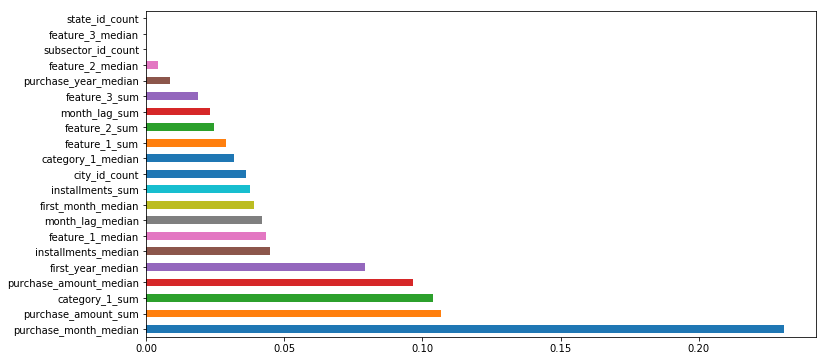

In [751]:
columns = final_train.drop("target_median",axis=1).columns

f, axes = plt.subplots(1, 1, figsize=(12, 6))
(pd.Series(classifier.feature_importances_, index=columns)
   .nlargest(len(classifier.feature_importances_))
   .plot(kind='barh'))

In [752]:
accuracies = cross_val_score(estimator = classifier, X = X, y = y, cv = 10, n_jobs = -1, scoring=make_scorer(rmse))
# print('- Accuracy using 10 folds is:', round((accuracies.mean()) * 100, 3), '%')
print('RMSE using 10 folds is: %f' % accuracies.mean())

RMSE using 10 folds is: 3.430145


In [753]:
# Predicting the test data
test_dataset = final_test.iloc[:, :-1].values

# Predict the survival of test dataset
prediction = {'card_id': final_test.index.values, 'target': classifier.predict(test_dataset)}

# Creating prediction file
solution = pd.DataFrame(prediction)
solution.to_csv('Final_Solution.csv', index=False)

In [760]:
len(test)

123623

In [759]:
len(final_test)

110015

In [486]:
train.corr()

,feature_1,feature_2,feature_3,target
feature_1,1.000000,-0.130969,0.583092,-0.014251
feature_2,-0.130969,1.000000,0.060925,-0.006242
feature_3,0.583092,0.060925,1.000000,-0.008125
target,-0.014251,-0.006242,-0.008125,1.000000


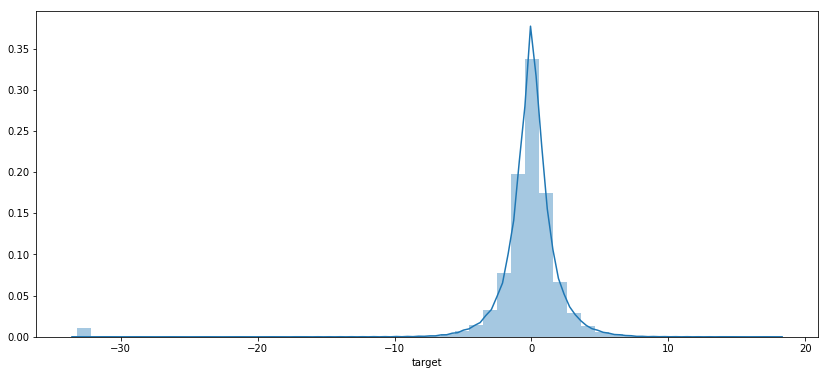

In [73]:
#histogram
f, ax = plt.subplots(figsize=(14, 6))
sns.distplot(train['target'])

In [77]:
train['target'].describe()

count    201917.000000
mean         -0.393636
std           3.850500
min         -33.219281
25%          -0.883110
50%          -0.023437
75%           0.765453
max          17.965068
Name: target, dtype: float64

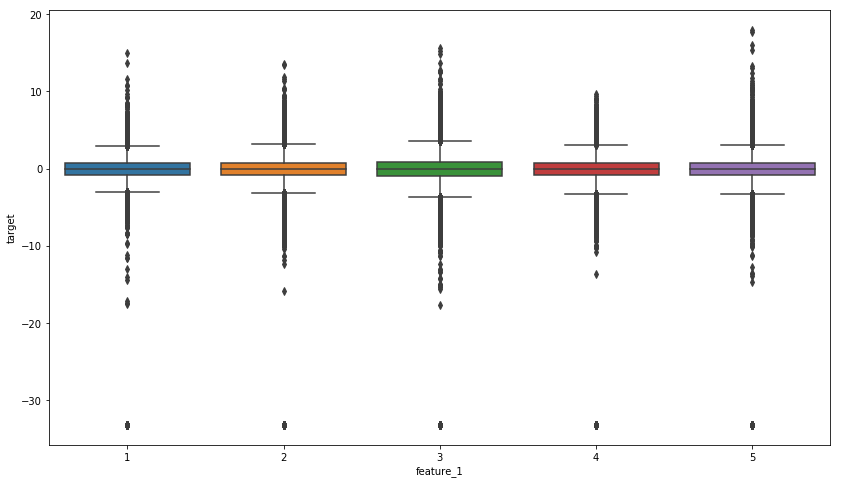

In [80]:
plt.subplots(figsize=(14, 8))
sns.boxplot(train.feature_1, train.target)

In [35]:
testat["binned_num_hist_transactions"].head()

0    (-0.75, -0.5]
1    (-0.75, -0.5]
2    (-0.75, -0.5]
3    (-0.75, -0.5]
4    (-0.5, -0.25]
Name: binned_num_hist_transactions, dtype: category
Categories (7, interval[float64]): [(-0.75, -0.5] < (-0.5, -0.25] < (-0.25, 0.0] < (0.0, 0.5] < (0.5, 1.0] < (1.0, 2.0] < (2.0, 10000000.0]]

In [32]:
cnt_srs

In [27]:
len(testat[testat['purchase_amount'] > 100000])

10

In [8]:
testat.purchase_amount.nunique()

179316

In [18]:
testat.loc[(testat['purchase_amount'] > -0.25), 'purchase_amount'] = 2

In [31]:
testat.purchase_amount.max()

6010603.9717525

In [22]:
testat.purchase_amount.nunique()

1

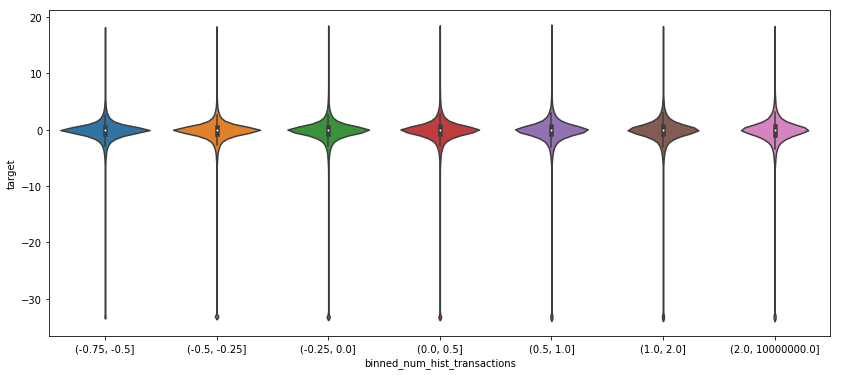

In [35]:
plt.figure(figsize=(14,6))
a1 = sns.violinplot(testat.binned_num_hist_transactions, testat.target)
plt.show()

In [274]:
historical_transactions.loc[(historical_transactions['purchase_amount'] > -0.75) & (historical_transactions['purchase_amount'] <= -0.5), 'purchase_amount'] = 0
historical_transactions.loc[(historical_transactions['purchase_amount'] > -0.5) & (historical_transactions['purchase_amount'] <= -0.25), 'purchase_amount'] = 1
historical_transactions.loc[historical_transactions['purchase_amount'] > -0.25,'purchase_amount'] = 2

In [271]:
len(testat.loc[(testat['purchase_amount'] > -0.75) & (testat['purchase_amount'] <= -0.5), 'purchase_amount'])


0

In [266]:
len(historical_transactions.loc[(historical_transactions['purchase_amount'] > -0.75) & (historical_transactions['purchase_amount'] <= -0.5), 'purchase_amount'])


25104077

In [272]:
len(testat.loc[(testat['purchase_amount'] > -0.5) & (testat['purchase_amount'] <= -0.25), 'purchase_amount'])


0

In [260]:
len(historical_transactions.loc[(historical_transactions['purchase_amount'] > -0.5) & (historical_transactions['purchase_amount'] <= -0.25), 'purchase_amount'])


2277290

In [273]:
len(testat.loc[(testat['purchase_amount'] > -0.25), 'purchase_amount'])


18030009

In [261]:
len(historical_transactions.loc[(historical_transactions['purchase_amount'] > -0.25), 'purchase_amount'])


1730994

In [275]:
historical_transactions.purchase_amount.nunique()

1

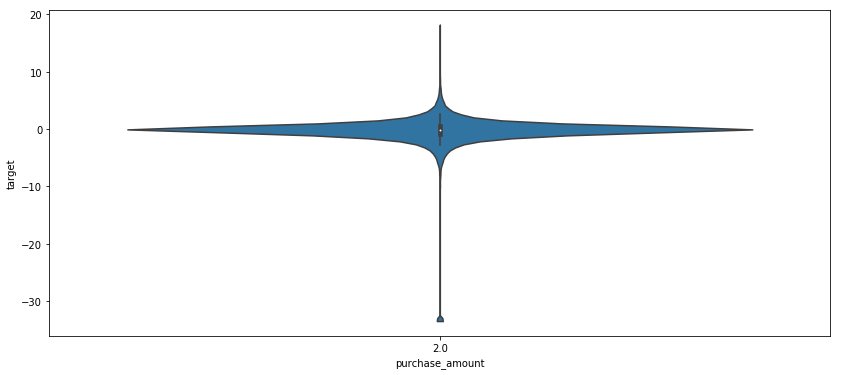

In [255]:
plt.figure(figsize=(14,6))
a1 = sns.violinplot(testat.purchase_amount, testat.target)
plt.show()

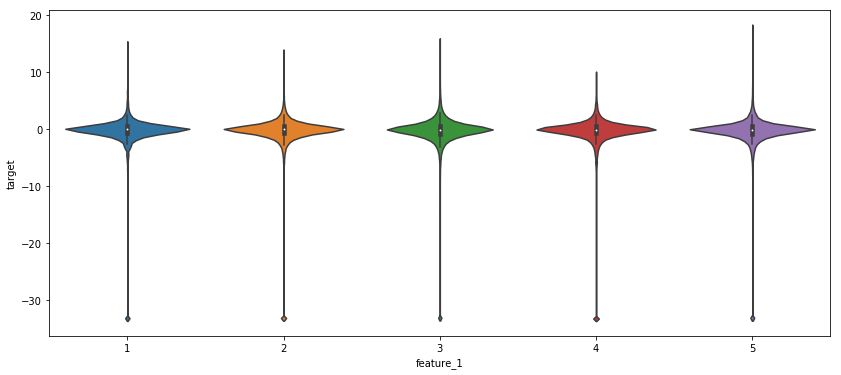

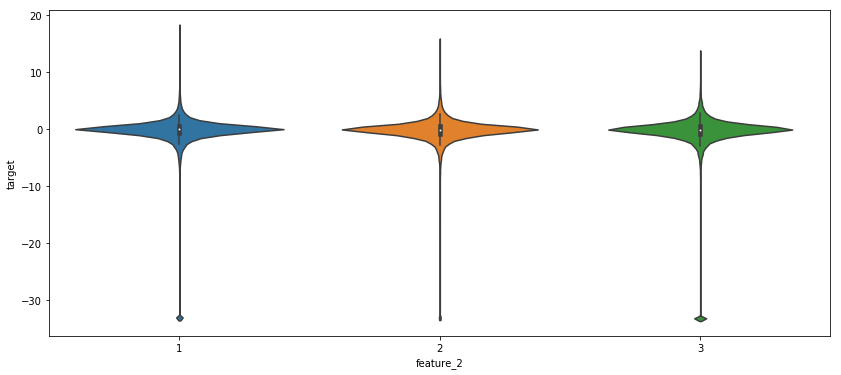

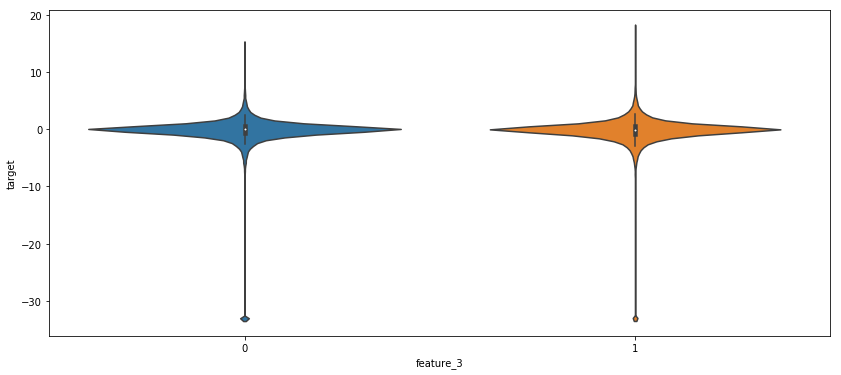

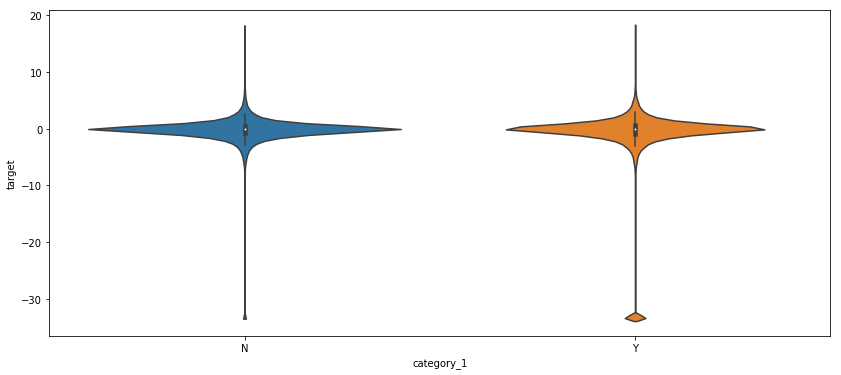

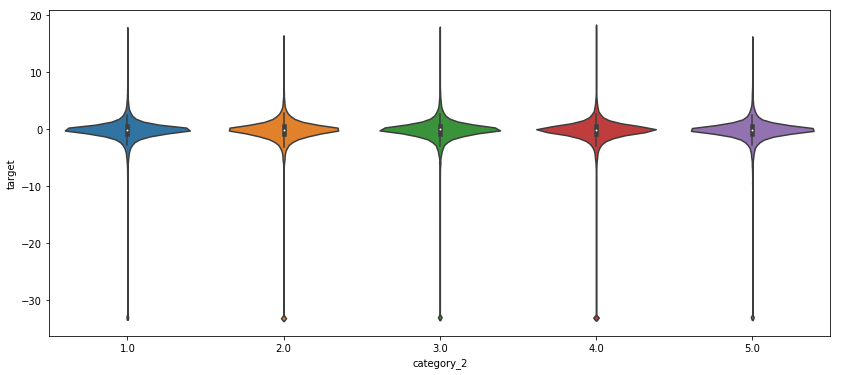

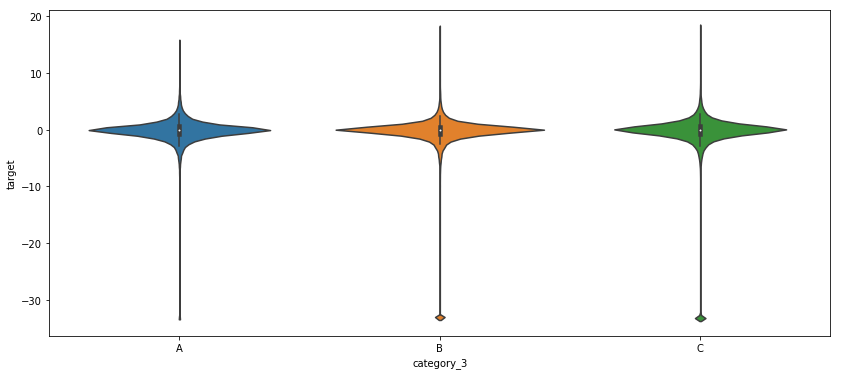

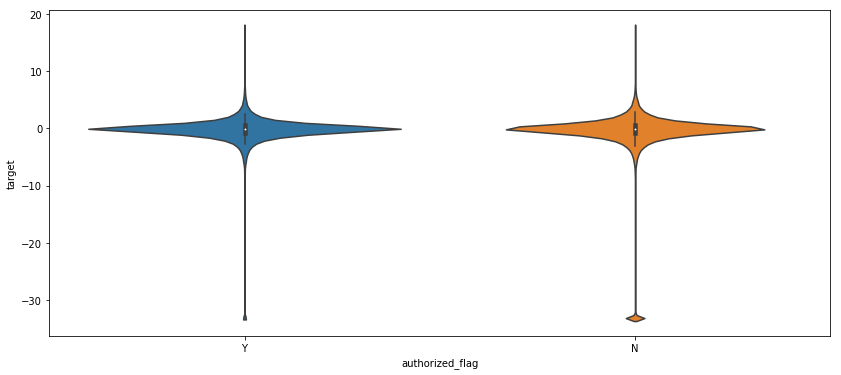

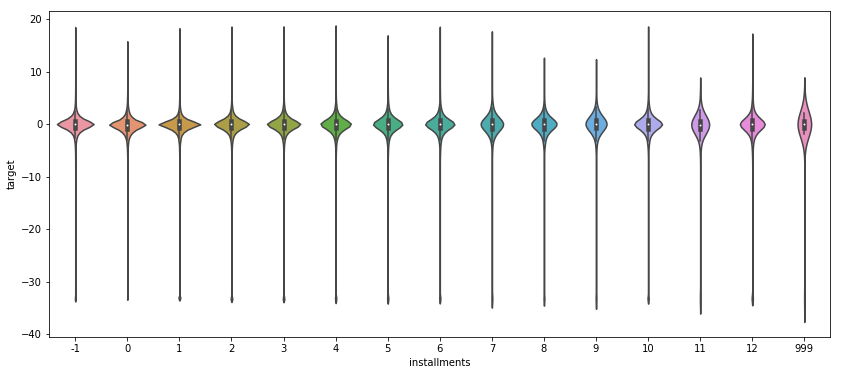

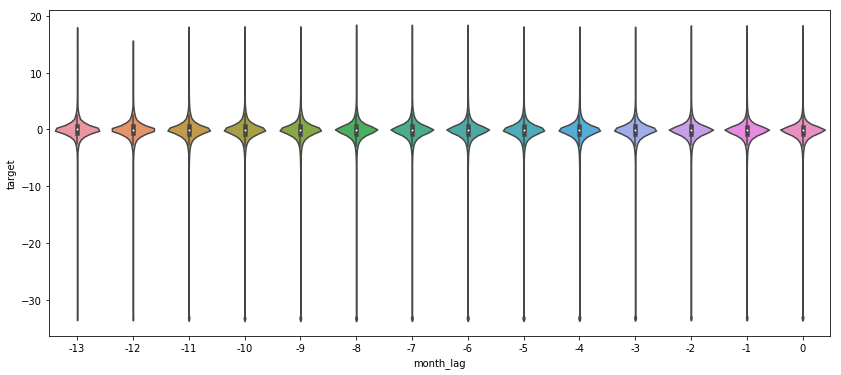

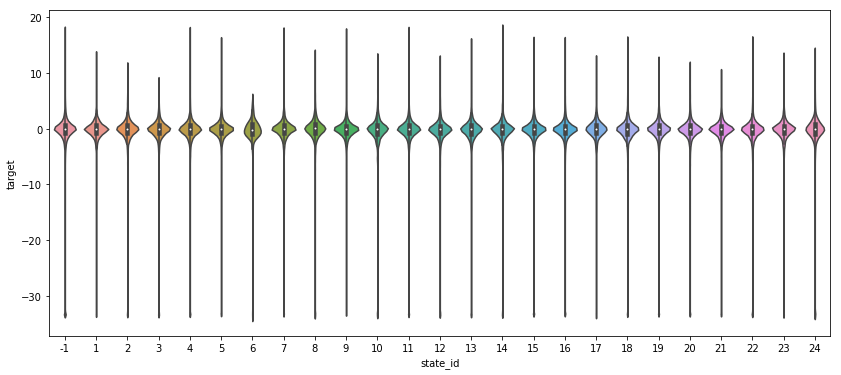

In [182]:
columns = ['feature_1', 'feature_2', 'feature_3', 'category_1', 'category_2', 'category_3', 'authorized_flag',
          'installments', 'month_lag', 'state_id']

for i in columns:
    plt.figure(figsize=(14,6))
    a1 = sns.violinplot(testat[i], testat.target)
    plt.show()

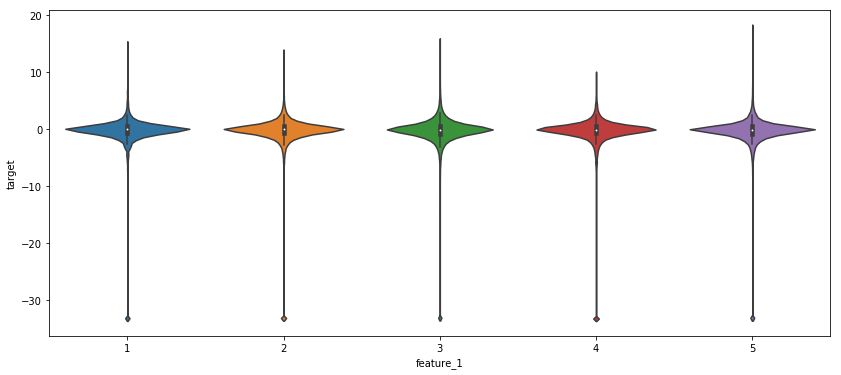

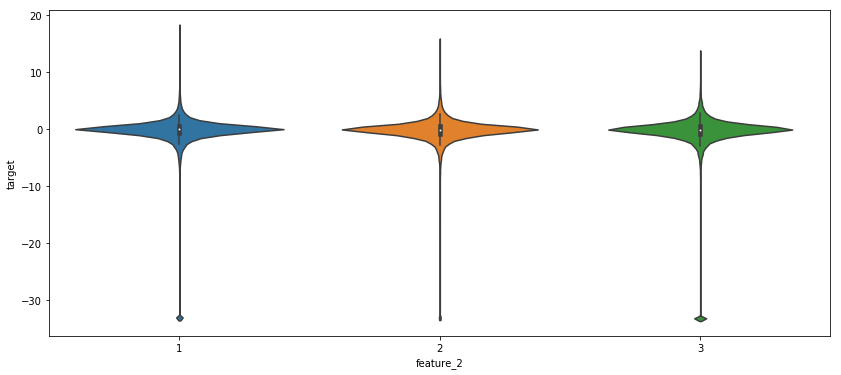

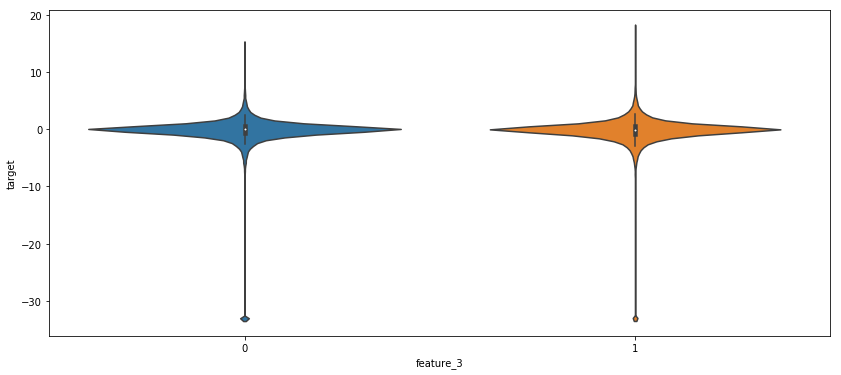

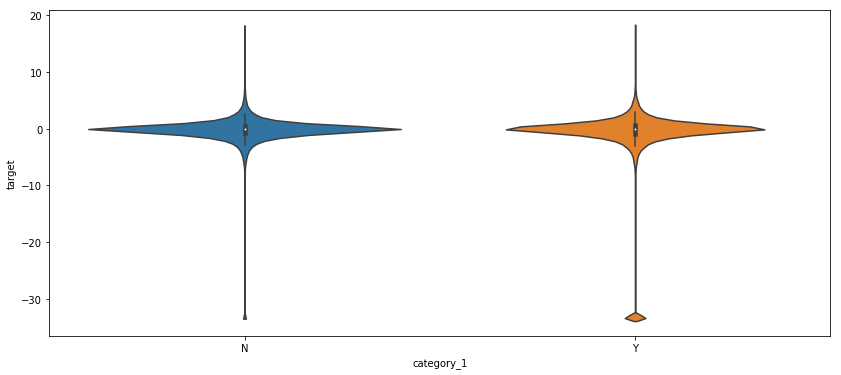

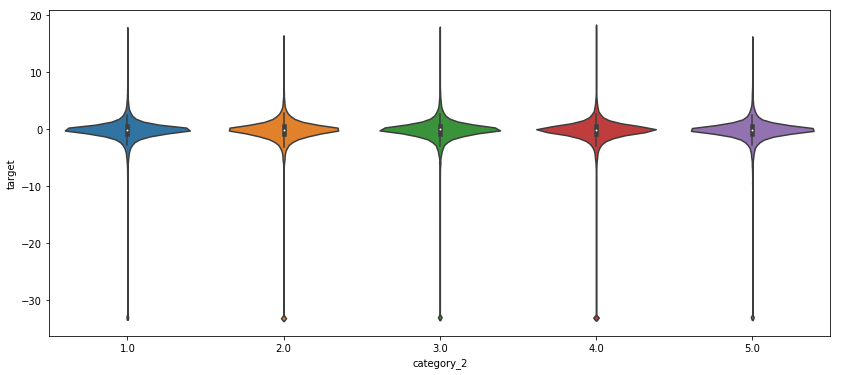

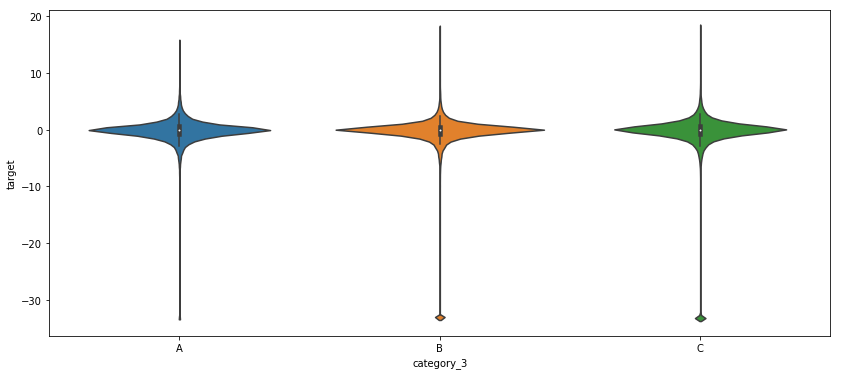

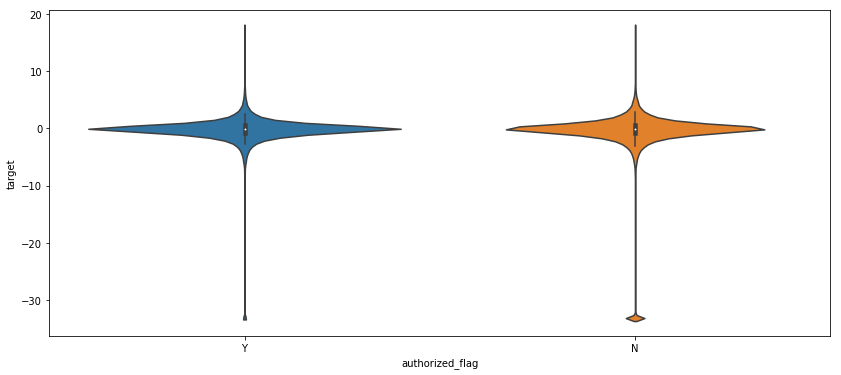

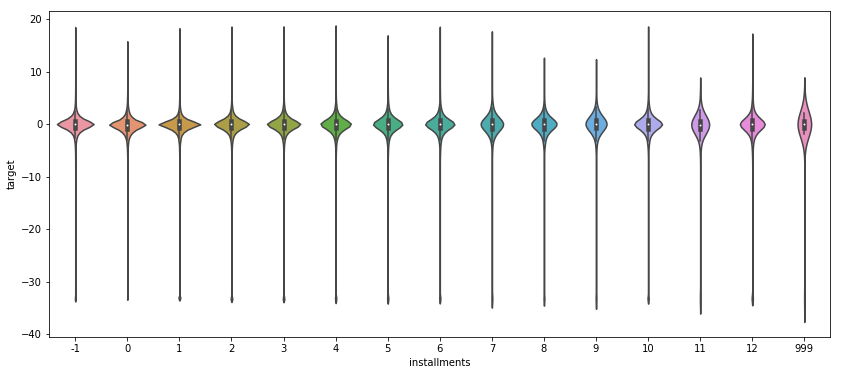

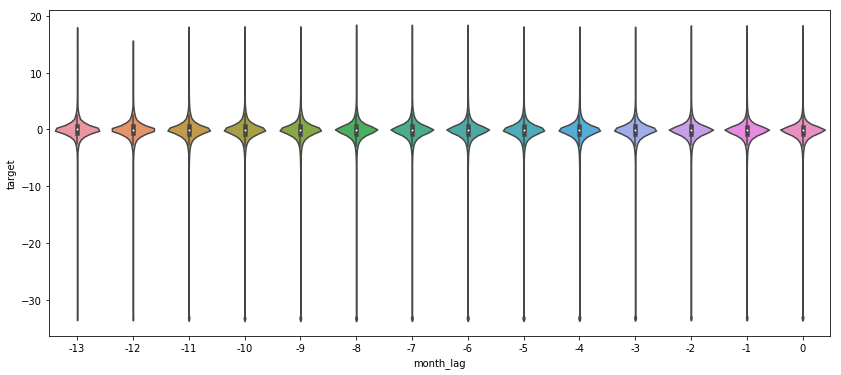

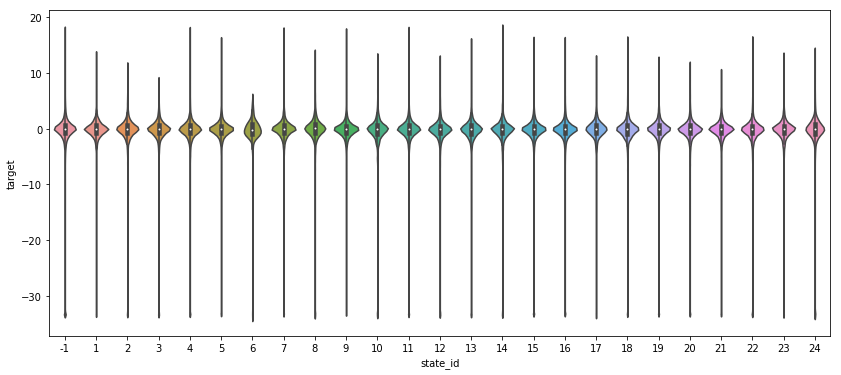

In [182]:
columns = ['feature_1', 'feature_2', 'feature_3', 'category_1', 'category_2', 'category_3', 'authorized_flag',
          'installments', 'month_lag', 'state_id']

for i in columns:
    plt.figure(figsize=(14,6))
    a1 = sns.violinplot(testat2[i], testat2.target)
    plt.show()

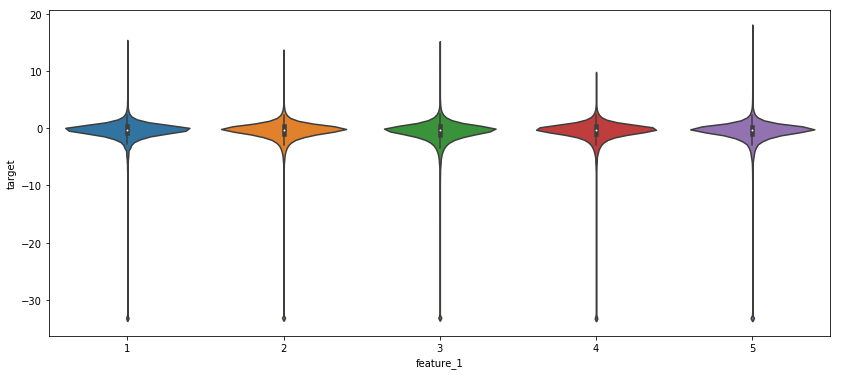

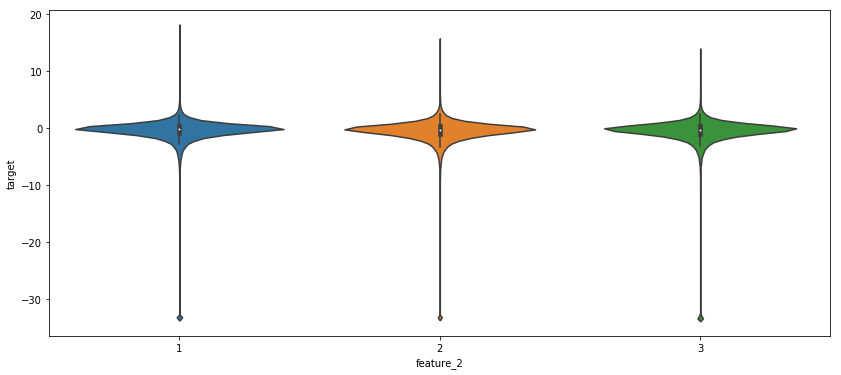

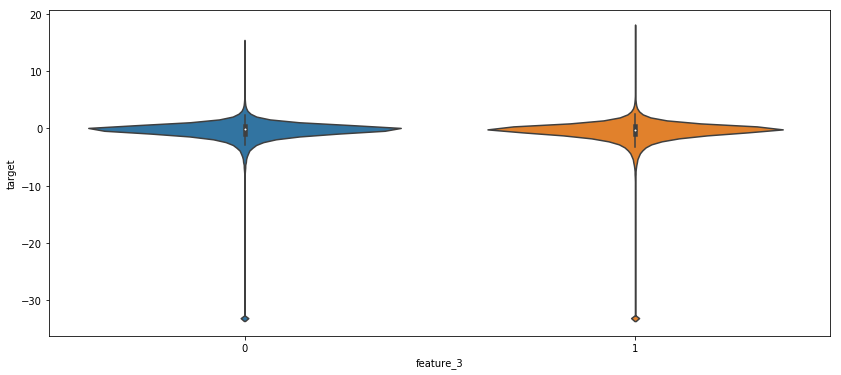

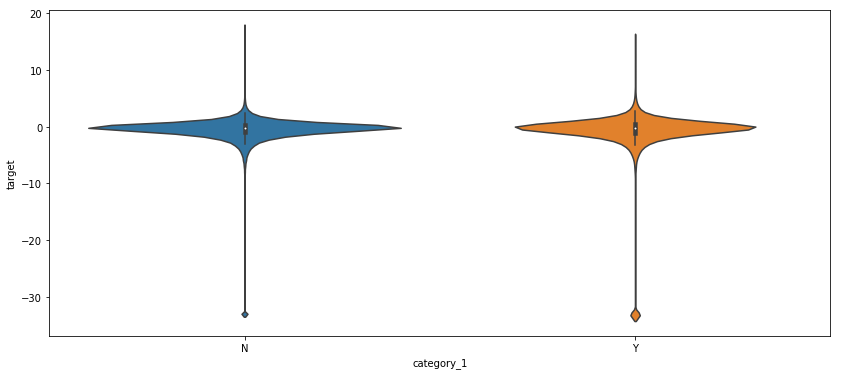

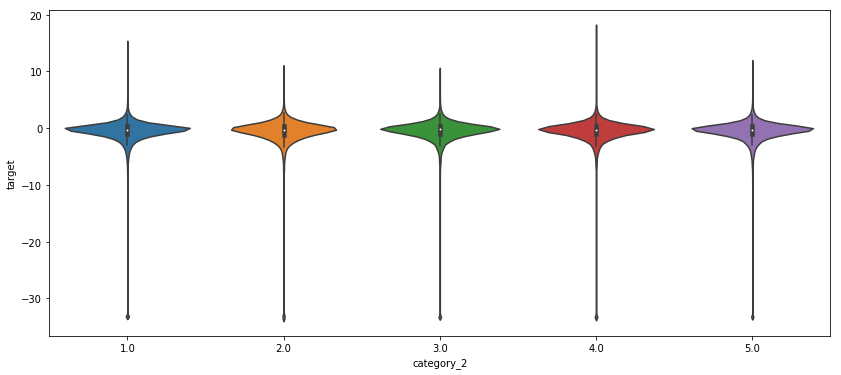

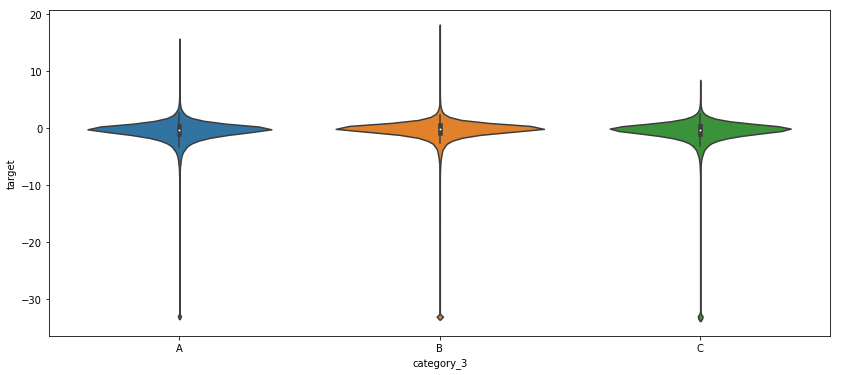

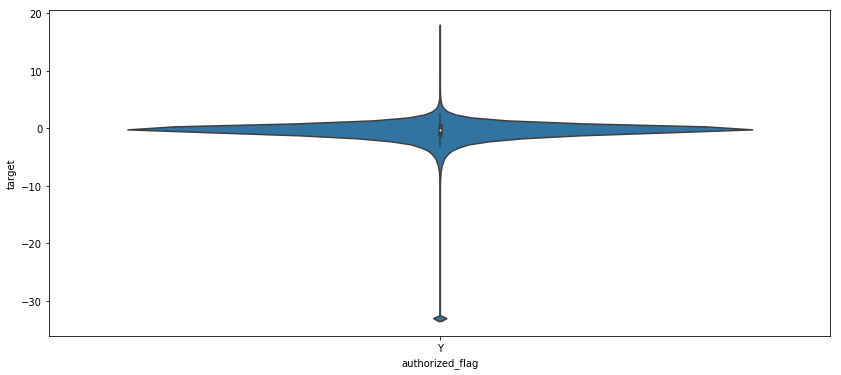

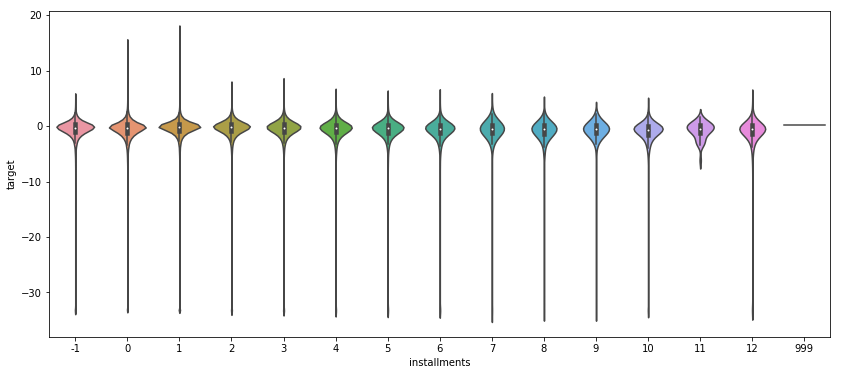

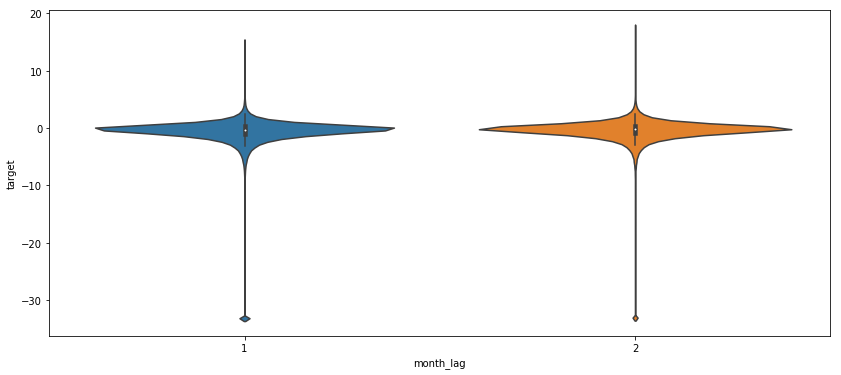

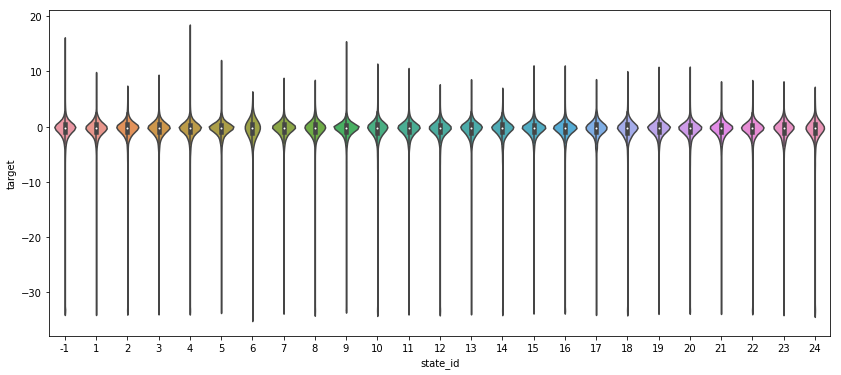

In [187]:
columns = ['feature_1', 'feature_2', 'feature_3', 'category_1', 'category_2', 'category_3', 'authorized_flag',
          'installments', 'month_lag', 'state_id']

for i in columns:
    plt.figure(figsize=(14,6))
    a1 = sns.violinplot(testat3[i], testat3.target)
    plt.show()

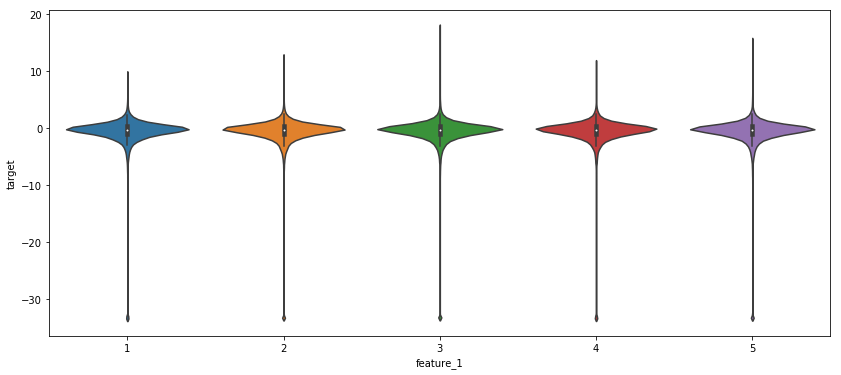

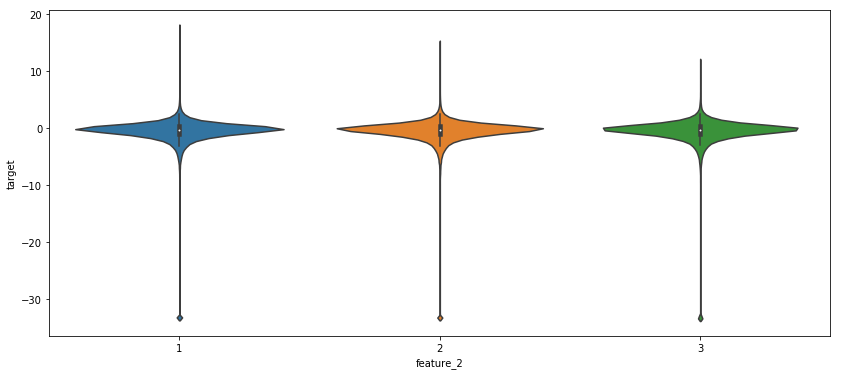

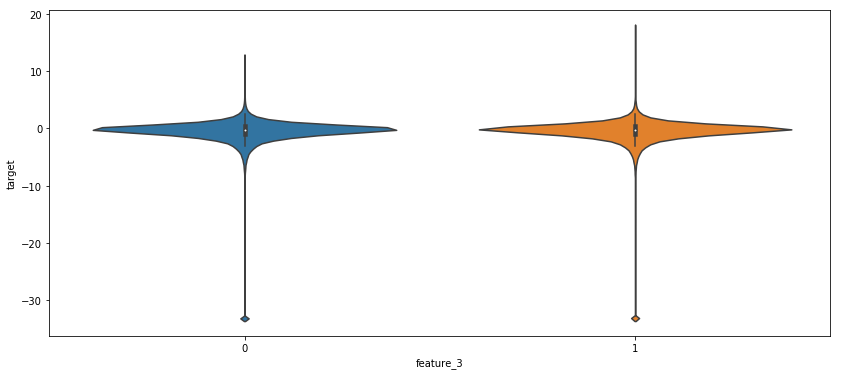

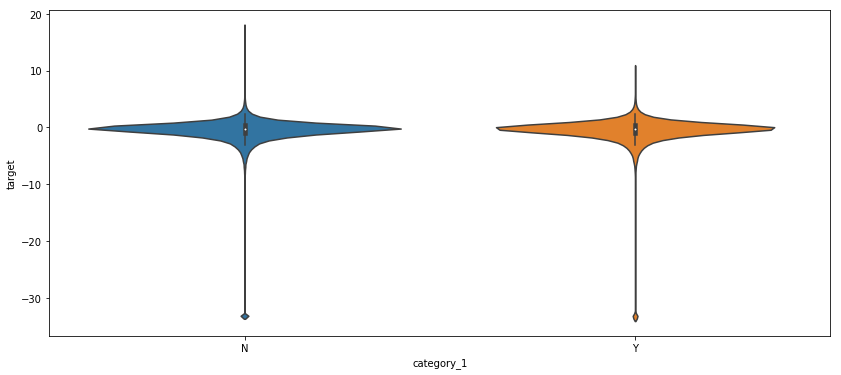

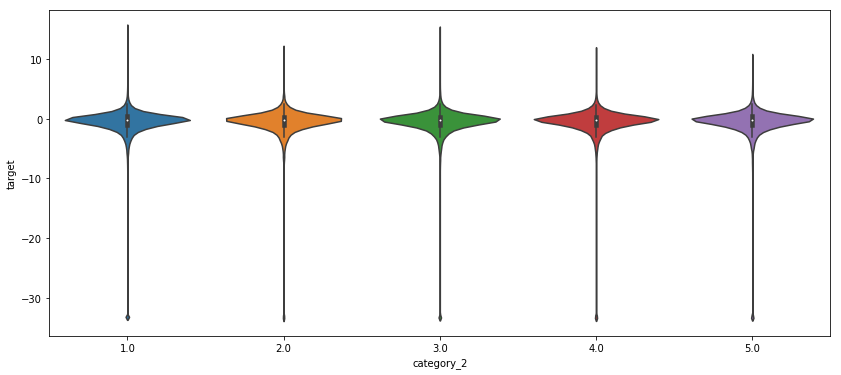

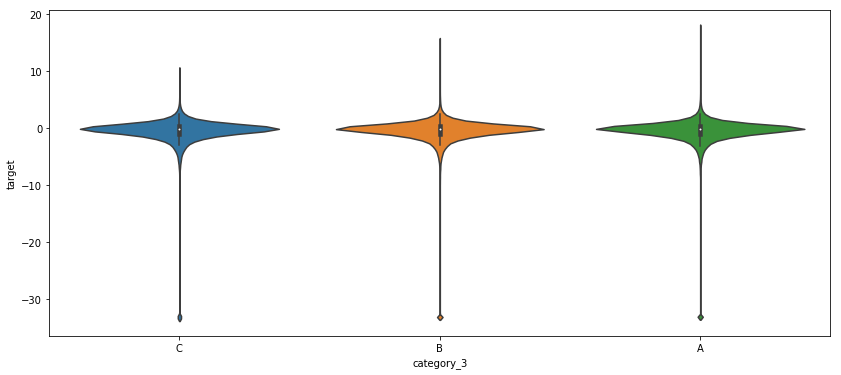

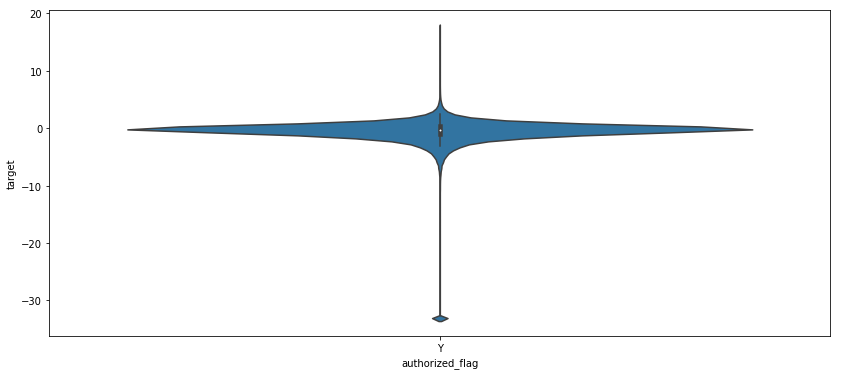

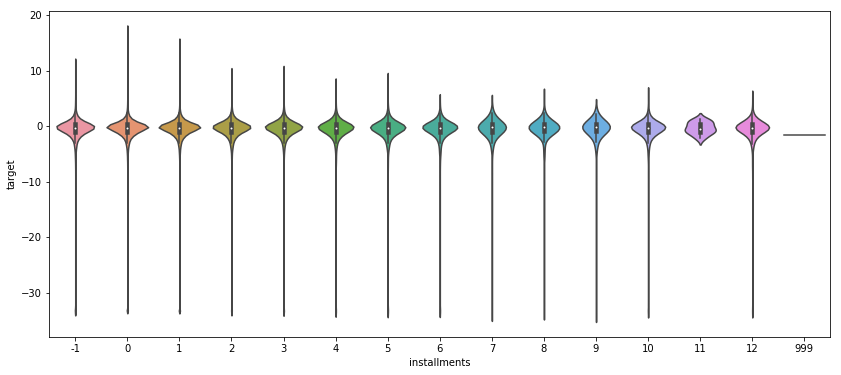

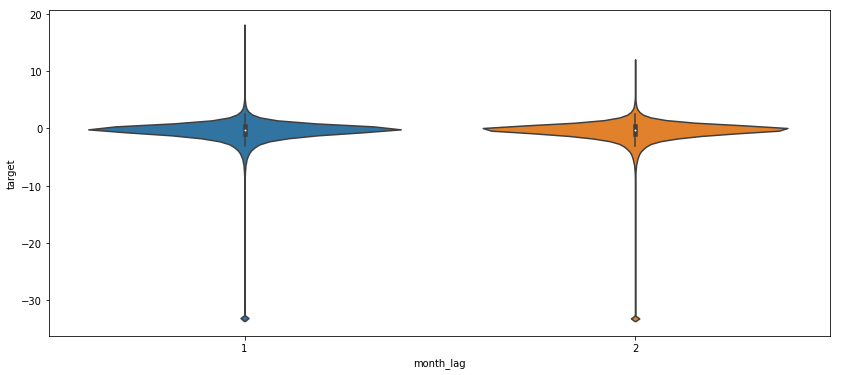

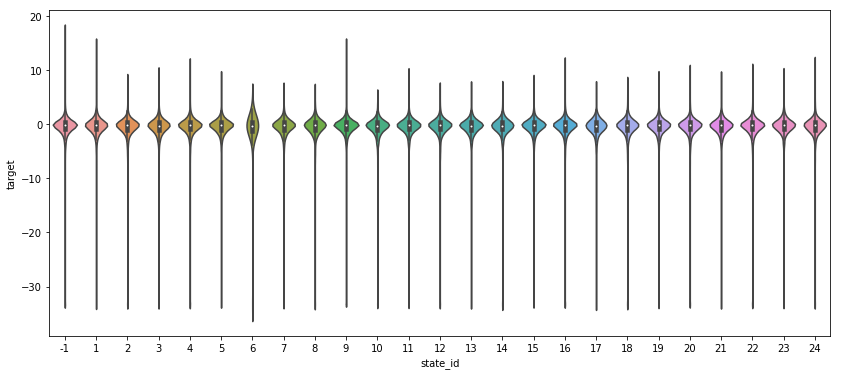

In [188]:
columns = ['feature_1', 'feature_2', 'feature_3', 'category_1', 'category_2', 'category_3', 'authorized_flag',
          'installments', 'month_lag', 'state_id']

for i in columns:
    plt.figure(figsize=(14,6))
    a1 = sns.violinplot(testat4[i], testat3.target)
    plt.show()

In [135]:
new_merchant_transactions.card_id.nunique()

290001

In [7]:
cnt_srs = train['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()

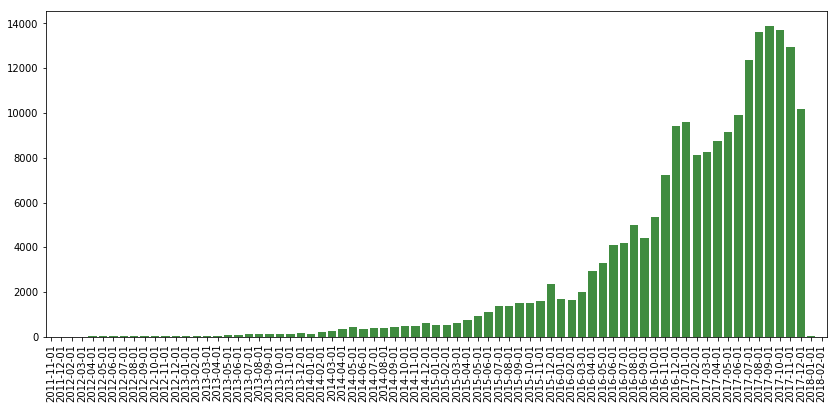

In [32]:
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.show()

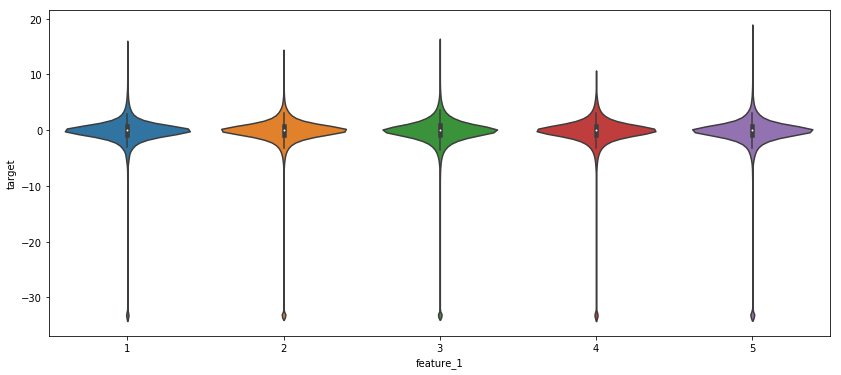

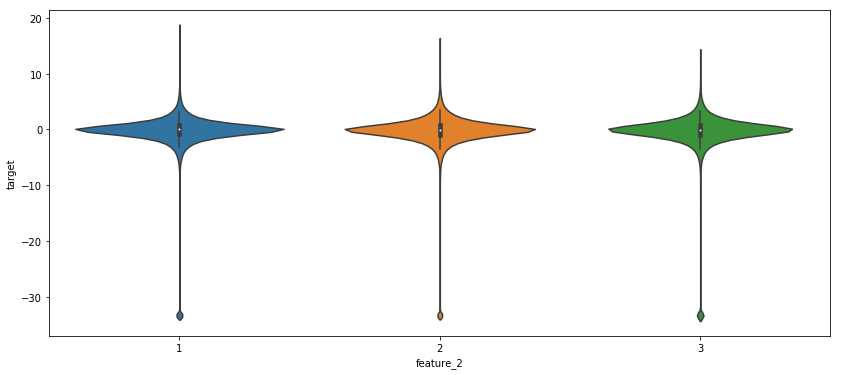

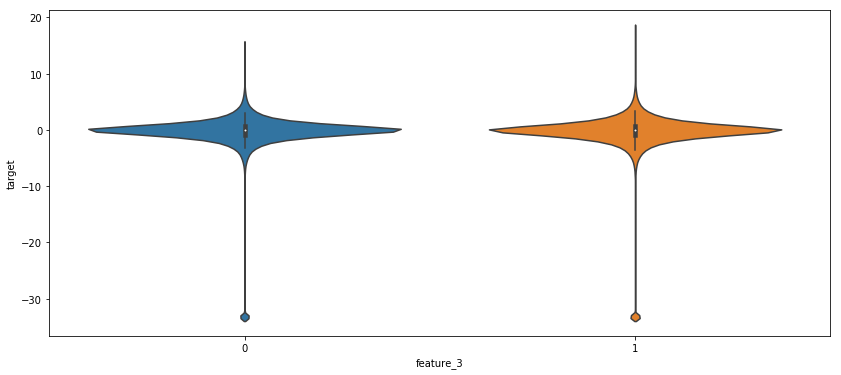

In [22]:
plt.figure(figsize=(14,6))
a1 = sns.violinplot(train['feature_1'], train.target)

plt.figure(figsize=(14,6))
a2 = sns.violinplot(train['feature_2'], train.target)

plt.figure(figsize=(14,6))
a3 = sns.violinplot(train['feature_3'], train.target)


In [131]:
test1 = pd.DataFrame({'first': [1, 1, 2, 2], 'second': [6, 7, 8, 9], 'third': range(11,15)})
test1

,first,second,third
0,1,6,11
1,1,7,12
2,2,8,13
3,2,9,14


In [132]:
test2 = pd.DataFrame({'first': range(1,6), 'second': range(21,26), 'third': range(26, 31)})
test2

,first,second,third
0,1,21,26
1,2,22,27
2,3,23,28
3,4,24,29
4,5,25,30


In [134]:
test1.merge(test2, on='first')

,first,second_x,third_x,second_y,third_y
0,1,6,11,21,26
1,1,7,12,21,26
2,2,8,13,22,27
3,2,9,14,22,27


In [56]:
pd.merge(test1, test2, on='first')

,first,second_x,third_x,second_y,third_y
0,1,6,11,21,26
1,2,7,12,22,27
2,3,8,13,23,28
3,4,9,14,24,29
4,5,10,15,25,30


In [57]:
historical_transactions.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,...,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [68]:
train[['card_id', 'target']].head()

,card_id,target
0,C_ID_92a2005557,-0.820283
1,C_ID_3d0044924f,0.392913
2,C_ID_d639edf6cd,0.688056
3,C_ID_186d6a6901,0.142495
4,C_ID_cdbd2c0db2,-0.159749


In [69]:
list1 = pd.merge(train[['card_id', 'target']], historical_transactions, on='card_id')

In [75]:
list1.head(1000).sort_values(by='card_id')

,card_id,target,authorized_flag,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
888,C_ID_0894217f2f,0.871585,Y,69,N,3,C,299,M_ID_c90c29ac55,-4,-0.144345,2017-03-22 21:56:12,1.0,9,41
864,C_ID_0894217f2f,0.871585,Y,69,N,3,C,884,M_ID_d13262f4b0,-1,-0.226990,2017-06-17 12:24:28,1.0,9,27
865,C_ID_0894217f2f,0.871585,Y,69,N,1,B,884,M_ID_7c26306ee3,-6,-0.626846,2017-01-11 15:56:13,1.0,9,27
866,C_ID_0894217f2f,0.871585,Y,69,N,3,C,884,M_ID_a6807b2866,0,-0.368540,2017-07-25 18:27:08,1.0,9,27
867,C_ID_0894217f2f,0.871585,Y,69,N,6,C,68,M_ID_18741e7c0e,-3,-0.258997,2017-04-25 14:25:55,1.0,9,27
868,C_ID_0894217f2f,0.871585,Y,69,N,1,B,884,M_ID_be022aff60,-1,-0.626726,2017-06-07 10:00:56,1.0,9,27
869,C_ID_0894217f2f,0.871585,Y,69,N,3,C,68,M_ID_8ae0933268,-3,-0.371410,2017-04-26 17:56:24,1.0,9,27
870,C_ID_0894217f2f,0.871585,Y,69,N,3,C,506,M_ID_cf3378cf31,-1,-0.440878,2017-06-16 13:02:41,1.0,9,30
871,C_ID_0894217f2f,0.871585,N,69,N,1,B,884,M_ID_d13262f4b0,-1,-0.611669,2017-06-26 14:49:35,1.0,9,27
872,C_ID_0894217f2f,0.871585,Y,69,N,1,B,884,M_ID_1abfe450d5,-4,-0.419330,2017-03-10 00:12:40,1.0,9,27


In [72]:
list2 = pd.merge(train[['card_id', 'target']], new_merchant_transactions, on='card_id')

In [79]:
list2.target.max()

17.67571588

In [76]:
list2.head(1000).sort_values(by='card_id')

,card_id,target,authorized_flag,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
228,C_ID_022b48f3ac,1.233601,Y,20,N,0,A,818,M_ID_b152a559cd,1,-0.694315,2018-01-05 21:04:00,3.0,19,12
226,C_ID_022b48f3ac,1.233601,Y,69,N,0,A,411,M_ID_4b30c89c1b,1,-0.718357,2018-01-12 12:00:08,1.0,9,21
229,C_ID_022b48f3ac,1.233601,Y,292,N,0,A,45,M_ID_5e92f6a3d4,1,-0.656749,2018-01-04 13:25:00,3.0,1,18
227,C_ID_022b48f3ac,1.233601,Y,107,N,0,A,278,M_ID_39833009b5,1,-0.658732,2018-01-06 11:44:34,4.0,4,37
932,C_ID_027f37fa0d,0.308151,Y,244,N,1,B,307,M_ID_8719245447,1,-0.671775,2018-03-13 13:52:44,3.0,2,19
933,C_ID_027f37fa0d,0.308151,Y,283,N,1,B,307,M_ID_658a9cff0d,1,-0.517002,2018-03-23 08:00:09,1.0,9,19
934,C_ID_027f37fa0d,0.308151,Y,283,N,1,B,705,M_ID_dad7a5a752,2,-0.706186,2018-04-19 16:15:59,1.0,9,33
935,C_ID_027f37fa0d,0.308151,Y,213,N,1,B,278,M_ID_d855771cd9,2,-0.625944,2018-04-28 13:09:25,1.0,9,37
936,C_ID_027f37fa0d,0.308151,Y,283,N,1,B,2,M_ID_991c74da69,1,-0.643976,2018-03-22 16:58:21,1.0,9,20
937,C_ID_027f37fa0d,0.308151,Y,69,N,1,B,259,M_ID_c14c60d011,2,-0.673203,2018-04-04 13:28:20,1.0,9,32


In [63]:
new_merchant_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [66]:
historical_transactions.month_lag.unique()

array([ -8,  -7,  -6,  -5, -11,   0,  -3,  -9,  -4,  -1, -13, -10, -12,
        -2])

In [80]:
result = pd.concat([historical_transactions, new_merchant_transactions])


In [111]:
len(historical_transactions)

29112361

In [112]:
len(result)

31075392

In [88]:
l1 = pd.merge(train, result, on='card_id')

In [90]:
l2 = pd.merge(test, result, on='card_id')

In [96]:
len(merchants)

334696

In [100]:
l1.merchant_id.nunique()

313541

In [101]:
l2.merchant_id.nunique()

288157

In [95]:
merchants.head().sort_values(by='merchant_id')

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,...,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0


In [105]:
ultimate1 = pd.merge(l1, merchants, on='merchant_id')

In [106]:
ultimate2 = pd.merge(l2, merchants, on='merchant_id')

In [110]:
len(ultimate1) + len(ultimate2)

32163978

In [109]:
ultimate1.merchant_group_id.nunique() + ultimate2.merchant_group_id.nunique()

212726